# Homework 07: Ensemble Methods – Bagging, Random Forests, and Gradient Boosting

## Due: Midnight on March 16 (with 2-hour grace period) and worth 75 points

Over the past two weeks, we have expanded our machine learning toolkit by moving beyond linear regression to explore decision trees, which introduced a variety of interacting parameters. Through Homework 6, you developed a systematic workflow for parameter tuning that balances manual exploration and automated searches (e.g., random or grid search) to optimize performance while gaining insights into model behavior.

This week, we take another step forward by studying ensemble methods which combine multiple decision trees to produce even stronger predictive models. Specifically, we will investigate:

- Bagging  
- Random Forests  
- Gradient Boosting  

These three approaches build on the decision tree we studied last week. Our  workflow from Homework 6 will again serve as the foundation for optimizing these more complex models.

### What We Will Do in This Homework

To analyze and optimize our ensemble models, we will apply the two-phase strategy introduced in Homework 6 (but with grid search rather than random grid search):

1. **First Phase:**  
   - Iteratively sweep through key parameters in coarse ranges  
   - Visualize training, validation, and test MSE  
   - Diagnose overfitting or underfitting  
   - Examine the standard deviation of CV scores to understand model stability (review Problems 1 & 2 in Homework 6)

2. **Second Phase:**  
   - Focus on the most unstable or promising parameter ranges found in Phase 1  
   - Perform an exhaustive search within these narrower ranges using `GridSearchCV` (review Problem 4 in Homework 6)

Refer to **Appendix 4** for more details.

We will follow this process for each of the three ensemble methods, systematically tuning their four most important parameters:

1. **Bagging Regressor:** `n_estimators`, `max_samples`, `max_features`, `bootstrap`  
2. **Random Forest Regressor:** `n_estimators`, `max_depth`, `max_features`, `bootstrap`  
3. **Gradient Boosting Regressor:** `learning_rate`, `n_estimators`, `max_depth`, `max_features`

Throughout this homework, we will continue using `RepeatedKFold` cross-validation to reduce variance in our CV MSE estimates. The default number of repetitions is 10, but you may find it necessary to reduce this when initially searching broad parameter spaces—then increase it for fine-tuning as you zero-in on the best models. 

As before, you will store your best parameter values (and the resulting CV MSE) in a dictionary in order to track improvements across experiments and maintain a clear record of how each parameter choice was made.

Before starting:
- Review lesson materials on ensemble methods and watch the three videos on Bagging, Random Forests, and Gradient Boosting.  
- Study the relevant appendices.  
- Pay special attention to the Gradient Boosting video and notebook, as the code in this homework builds on (and has been adapted from) those resources.

### Grading

This homework consists of 15 graded problems, each worth 5 points, for a total of 75 points.

In [4]:
# Useful imports

import os
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import io
import zipfile
import time
import datetime
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold,GridSearchCV
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics         import mean_squared_error
from tqdm                    import tqdm

import matplotlib.ticker as mticker           # Optional: you can print out y axis labels as dollars. 

# globals

random_state = 42

# utility code

# Completely optional:  Format y-axis labels as dollars with commas
def dollar_format(x, pos):
    return f'${x:,.0f}'

def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

### Load the Ames Housing Dataset  

The code cell below will load the dataset for you.  This is the same dataset we used for the last two homeworks. 

> **Notice** that this code includes a useful optimization: **before downloading, it first
checks whether the files already exist.** This is a essential step when working with large datasets or when building deep learning models, where training can span hours or even days. By reusing previously downloaded files or saved models, you can avoid unnecessary work and significantly speed up your workflow.

For a detailed description of the dataset features, please refer to the **Appendix** in Homework 05. 

In [14]:
data_dir = "Ames_Dataset"                              # Directory where files will be stored

# Check if one of the files exists; if not, download and extract the zip file

if not os.path.exists( os.path.join(data_dir, "X_train.csv") ):
    print("Dataset files not found. Downloading...")
    zip_url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/ames_housing.zip"
    try:
        response = requests.get(zip_url)
        response.raise_for_status()  # Raise an error for bad status codes
        # Extract the zip file into the designated directory
        with zipfile.ZipFile(io.BytesIO(response.content)) as zipf:
            zipf.extractall(data_dir)
        print("Files downloaded and extracted successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("Dataset files already exist. Skipping download.")

# Load the datasets
X_train = pd.read_csv(os.path.join(data_dir, "X_train.csv"))
X_test  = pd.read_csv(os.path.join(data_dir, "X_test.csv"))
y_train = pd.read_csv(os.path.join(data_dir, "y_train.csv")).squeeze("columns")    
y_test  = pd.read_csv(os.path.join(data_dir, "y_test.csv")).squeeze("columns")

print("Training and testing datasets loaded successfully.")


Dataset files already exist. Skipping download.
Training and testing datasets loaded successfully.


## Prelude: Wrapper Functions for Running Ensemble Models

The following cells are adapted from the Week 7 video notebook on `GradientBoostingRegressor`, but have been refactored so that they can handle any of the three ensemble models (Bagging, Random Forest, or Gradient Boosting). Key changes include:

- **`run_model`** replaces the original `run_gradient_boosting_regressor` and accepts a parameter dictionary that can be applied to any of the three ensemble models.  
- **`sweep_parameter`** is updated to work seamlessly with `run_model`, letting you:
  - Specify which ensemble model you want to use.  
  - Pass a dictionary of model parameters.  
  - Return a modified parameter dictionary reflecting the best value of the parameter you swept, along with the corresponding MSE  (note that RMSE is **only** used for printing out results)

> **Note:** Please do not change these cells unless you consult with the LFs first. Any alterations may cause downstream issues with the assignment.

In [28]:
def add_run_results(results_df, model_name, param_name, parameter_value,
                    cv_mse, std_cv, train_mse, test_mse,
                    sweep_name=None, part_name=None,
                    start_time=None, end_time=None,
                    print_results=True):
    """
    Gathers results from a single run inside sweep_parameter() and appends to results_df.
    
    Parameters:
    - results_df: pd.DataFrame or None
    - model_name: str (e.g., "RandomForestRegressor")
    - param_name: str (the hyperparameter you're sweeping, e.g., 'n_estimators')
    - parameter_value: value tested in this iteration (e.g., 100)
    - cv_mse, std_cv, train_mse, test_mse: numeric results from the model run
    - sweep_name: str (optional, e.g., "Sweep 1")
    - part_name: str (optional, e.g., "Task 1A")
    - start_time, end_time: timestamps (optional)
    
    Returns:
    - Updated pd.DataFrame
    """

    # Basic record for this iteration
    record = {
        "Model": model_name,
        "Sweep": sweep_name,
        "Part": part_name,
        "Param_Sweep": param_name,
        "Param_Value": parameter_value,
        # RMSE
        "Mean_CV_RMSE": np.sqrt(cv_mse),
        "Std_CV_RMSE": np.sqrt(std_cv),
        "Train_RMSE": np.sqrt(train_mse),
        "Test_RMSE": np.sqrt(test_mse),
        # MSE
        "Mean_CV_MSE": cv_mse,
        "Std_CV_MSE": std_cv,
        "Train_MSE": train_mse,
        "Test_MSE": test_mse,
    }

    # Add timing info if available
    if start_time and end_time:
        runtime_sec = (end_time - start_time).total_seconds()
        record["Start_Time"] = start_time
        record["End_Time"] = end_time
        record["Runtime_sec"] = runtime_sec

    # Turn it into a DataFrame row
    run_df = pd.DataFrame([record])

    # Append to results_df
    if results_df is None:
        results_df = run_df
    else:
        results_df = pd.concat([results_df, run_df], ignore_index=True)

    # Print formatted output
    if print_results:
        print("\n----- Run Results -----")
        print(f"Model       : {model_name}")
        if sweep_name: print(f"Sweep       : {sweep_name}")
        if part_name: print(f"Part        : {part_name}")
        print(f"Parameter   : {param_name} = {parameter_value}")
        print(f"Mean CV MSE : {cv_mse:.4f}")
        print(f"Std CV MSE  : {std_cv:.4f}")
        print(f"Train MSE   : {train_mse:.4f}")
        print(f"Test MSE    : {test_mse:.4f}")
        if start_time and end_time:
            print(f"Runtime     : {runtime_sec:.2f} seconds")
        print("-----------------------\n")

    return results_df


In [16]:
def get_best_params(results_df, sweep_name, part_name):
    """
    Filter results_df by sweep and part name,
    find the row with the lowest Mean_CV_MSE,
    and return it as a dictionary.
    
    Parameters:
    - results_df: DataFrame with all runs
    - sweep_name: str, name of the sweep to filter by
    - part_name: str, name of the part/task to filter by
    
    Returns:
    - Dictionary of the best parameters + metrics
    """
    
    # Filter the DataFrame
    filtered_df = results_df[
        (results_df['Sweep'] == sweep_name) &
        (results_df['Part'] == part_name)
    ]
    
    if filtered_df.empty:
        print(f"No results found for Sweep: {sweep_name} and Part: {part_name}")
        return None
    
    # Find index of row with minimal Mean_CV_MSE
    best_idx = filtered_df['Mean_CV_MSE'].idxmin()
    
    # Get that row as a Series
    best_row = results_df.loc[best_idx]
    
    # Convert to dictionary (optional: drop columns if not needed)
    best_params_dict = best_row.to_dict()
    
    return best_params_dict

In [17]:
n_repeats = 1
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=n_repeats, n_jobs=-1, **model_params):

    # Remove non-model keys
    for key in ['MSE_found', 'RMSE_found']:
        model_params.pop(key, None)
    
    if isinstance(model, type):
        model = model(**model_params)
    else:
        model.set_params(**model_params)

    neg_mse_scores = cross_val_score(model, X_train, y_train,scoring = 'neg_mean_squared_error',
                                     cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=42), 
                                     #cv = 5,
                                     n_jobs  = n_jobs)
    
    mean_cv_mse = -np.mean(neg_mse_scores)
    std_cv_mse  = np.std(neg_mse_scores)
    
    # Fit the model on the full training set
    model.fit(X_train, y_train)
    
    # Compute training MSE and testing MSE
    train_preds = model.predict(X_train)
    train_mse   = mean_squared_error(y_train, train_preds)
    test_preds  = model.predict(X_test)
    test_mse    = mean_squared_error(y_test, test_preds)
    
    return mean_cv_mse, std_cv_mse, train_mse, test_mse


In [ ]:
def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = n_repeats):
    
    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary
    
    cv_mses, std_cvs, train_mses, test_mses = [], [], [], []
    no_improve_count = 0
    best_mse = float('inf')
    
    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove MSE_found if present, just in case
        P_temp.pop('MSE_found', None)
        P_temp.pop('RMSE_found', None)
        
        cv_mse, std_cv, train_mse, test_mse = run_model(
            model=model,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_mses.append(cv_mse)
        std_cvs.append(std_cv)
        train_mses.append(train_mse)
        test_mses.append(test_mse)
        
        # Early-stopping logic
        if cv_mse < best_mse - delta:
            best_mse = cv_mse
            no_improve_count = 0
        else:
            no_improve_count += 1
        
        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break
    
    # Identify best parameter
    min_cv_mse = min(cv_mses)
    min_index = cv_mses.index(min_cv_mse)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['MSE_found'] = min_cv_mse
    
    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
        
        # We only need as many parameter values as we actually computed
        partial_param_list = parameter_list[:len(cv_mses)]
        
        # Check if our parameter list is Boolean so we can label accordingly
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            # Treat numeric or other types as-is
            x_vals = partial_param_list
            x_labels = partial_param_list
        
        error_name = 'RMSE' if show_rmse else 'MSE'
        
        # ----- First plot: (R)MSE -----
        ax1.set_title(f"{error_name} vs {param}")
        
        # Apply dollar formatting ONLY if we're showing RMSE
        if show_rmse:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))
        
        # Plot lines
        ax1.plot(x_vals,
                 np.sqrt(cv_mses) if show_rmse else cv_mses,
                 marker='.', label=f"CV {error_name}", color='blue')
        ax1.plot(x_vals,
                 np.sqrt(train_mses) if show_rmse else train_mses,
                 marker='.', label=f"Train {error_name}", color='green')
        ax1.plot(x_vals,
                 np.sqrt(test_mses) if show_rmse else test_mses,
                 linestyle='--', label=f"Test {error_name}", color='orange')
        ax1.scatter([x_vals[min_index]],
                    [np.sqrt(min_cv_mse) if show_rmse else min_cv_mse], s = 100 ,
                    marker='x', label=f"Best CV {error_name}", color='red')
        
        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()
        
        # ----- Second plot: CV Std Dev -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label=f"CV {error_name} Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)
        
        # If we are using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)
        
        plt.tight_layout()
        plt.show()
        
        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))
    
    return Parameters


### Supporting functions

In [19]:
def add_run_results(results_df, model_name, metrics_dict, hyperparams=None,
                    start_time=None, end_time=None,
                    sweep_name=None, part_name=None):
    """
    Add results from a modeling run to an existing DataFrame, including runtime, sweep, and part names.
    
    Parameters:
    - results_df: pd.DataFrame or None, existing results table.
    - model_name: str, name of the model.
    - metrics_dict: dict, output metrics from evaluation (cv mse, train mse, etc.).
    - hyperparams: dict, model hyperparameters (optional).
    - start_time: datetime.datetime, timestamp of the start (optional).
    - end_time: datetime.datetime, timestamp of the end (optional).
    - sweep_name: str, experiment sweep identifier (optional).
    - part_name: str, task or part identifier (optional).
    
    Returns:
    - Updated pd.DataFrame
    """
    # Base record
    record = {
        "Model": model_name,
        "Mean_CV_MSE": metrics_dict.get("mean_cv_mse"),
        "Std_CV_MSE": metrics_dict.get("std_cv_mse"),
        "Train_MSE": metrics_dict.get("train_mse"),
        "Test_MSE": metrics_dict.get("test_mse"),
    }

    # Add hyperparameters (flatten dictionary)
    if hyperparams:
        for param, value in hyperparams.items():
            record[f"Param_{param}"] = value

    # Add runtime tracking
    if start_time and end_time:
        runtime_sec = (end_time - start_time).total_seconds()
        record["Start_Time"] = start_time
        record["End_Time"] = end_time
        record["Runtime_sec"] = runtime_sec

    # Add sweep and part names
    if sweep_name:
        record["Sweep"] = sweep_name
    if part_name:
        record["Part"] = part_name

    # Create a new DataFrame for this record
    run_df = pd.DataFrame([record])

    # Append to existing results_df or create new
    if results_df is None:
        results_df = run_df
    else:
        results_df = pd.concat([results_df, run_df], ignore_index=True)

    return results_df


In [20]:
def get_best_params(results_df, sweep_name):
    """
    Filter results_df by sweep and part name,
    find the row with the lowest Mean_CV_MSE,
    and return it as a dictionary.
    
    Parameters:
    - results_df: DataFrame with all runs
    - sweep_name: str, name of the sweep to filter by
    - part_name: str, name of the part/task to filter by
    
    Returns:
    - Dictionary of the best parameters + metrics
    """
    
    # Filter the DataFrame
    filtered_df = results_df[
        (results_df['Sweep'] == sweep_name) 
    ]
    
    if filtered_df.empty:
        print(f"No results found for Sweep: {sweep_name}")
        return None
    
    # Find index of row with minimal Mean_CV_MSE
    best_idx = filtered_df['Mean_CV_MSE'].idxmin()
    
    # Get that row as a Series
    best_row = results_df.loc[best_idx]
    
    # Convert to dictionary (optional: drop columns if not needed)
    best_params_dict = best_row.to_dict()
    
    return best_params_dict

def get_best_param_only(results_df, sweep_name):
    best_run = get_best_params(results_df, sweep_name)
    
    if best_run is None:
        return None
    
    param_name = best_run['Param_Sweep']
    param_value = best_run['Param_Value']
    
    return {param_name: param_value}

In [21]:
sweep_results_df = pd.DataFrame()
n_repeats=2

## **Problem One: Bagging Trees**  

In this problem, you will follow a structured workflow to tune and evaluate a **Bagging Regressor**. The process builds on the approach from the last two homeworks; note that, as Homework 06, we will apply **grid search** to systematically explore parameter values.  Note that we will **not** be used Early Stopping in this homework; this will be a valuable technique going forward, but in this homework we are still learning how these complex models perform.

At the end of the analysis, you will not simply select the model with the lowest CV MSE score. Instead, you will critically examine the plots to determine whether another model configuration provides a better balance between performance, stability, and generalization. This step is essential for ensuring that your chosen model will perform well on new data. The criteria we will use for this choice are in **Appendix 5** below. 

### **Part 1.A: Iteratively Sweep Parameters and Visualize Results using `sweep_parameter(...)`**  
We will start with the `Default_Parameters_Bagging` dictionary and iteratively adjust key parameters. At each step, using the code provided above, you will:  

- Test a range of values for the specified parameter.
- Plot training, repeated cross-validation, and test MSE to diagnose overfitting or underfitting.
- Plot the standard deviation of the CV scores to assess model stability.
- Store the best value (which produces the minimum CV MSE) in a dictionary, perhaps called `Parameters_BT`.

**You should read Appendix 4 now if you have not done so already.**

**Step-by-step process:**
1. **Sweep `n_estimators`** (integer values):  
   - Begin by *making a copy* of the provided `Default_Parameters_Bagging` dictionary.  
   - Sweep a range of **integer** values for `n_estimators` (the number of base learners).  
   - Store the best value in `Parameters_BT`. 

2. **Sweep `max_samples`** (float values):  
   - Using `Parameters_BT`, test a range of **float** values for `max_samples`.  
   - Store the best value in `Parameters_BT`. (*Note: This may simply be the default value!*)

3. **Sweep `max_features`** (integer values):  
   - Using `Parameters_BT`, test a range of **integer** values for `max_features`.  
   - Store the best value in `Parameters_BT`. (*Again, the best value might be the default!*)

4. **Sweep `bootstrap`** (Boolean values):  
   - Test both possible values (`True` and `False`).  
   - Store the best value in `Parameters_BT`.

5. **Report your final results (including all final parameter choices, and convert MSE to RMSE in dollars when printing out)** and answer the graded question. 

In [22]:
# Define the parameters for the BaggingRegressor
Default_Parameters_Bagging = {
    'n_estimators': 10,            # Number of base estimators in the ensemble
    'max_samples' : 1.0,           # Fraction of samples to draw for each base estimator
    'max_features': 1.0,           # Fraction of features to consider for each estimator
    'bootstrap'   : True,          # Use bootstrap samples when building estimators
    'random_state': 42,            # Ensures reproducibility
    'MSE_found'   : float('inf')   # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                   # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}


In [23]:
# Set some global variables for the parameter sweeps
augmented_bagging_result_list = []
augmented_bagging_result = []
Parameters_BT_list = []


In [24]:
log_file = 'logs/hw07_log'
def log_message(text, log_file=log_file):
    timestamp = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    log_entry = f"[{timestamp}] {text}"
    log_file = log_file + datetime.datetime.now().strftime('%Y%m%d') + '.log'
    with open(log_file, 'a') as f:
        f.write(log_entry + '\n')


# log_message(f'{augmented_bagging_result}')


In [9]:
# 0. All defaults: 
model_all_defaults = BaggingRegressor
P_temp = Default_Parameters_Bagging.copy()
cv_mse, std_cv, train_mse, test_mse = run_model(
            model=model_all_defaults,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=-1,
            **P_temp
        )


In [10]:
all_defaults_cv_rmse = np.sqrt(cv_mse)
print(f"cv_rmse: {all_defaults_cv_rmse},cv_mse: {cv_mse}, std_cv: {std_cv}, train_mse: {train_mse}, test_mse: {test_mse}")

# Lists:
augmented_bagging_result = Default_Parameters_Bagging.copy()
augmented_bagging_result['MSE_found']=cv_mse
augmented_bagging_result['RMSE_found']=all_defaults_cv_rmse
augmented_bagging_result_list.append(augmented_bagging_result)
print(f"defaults: {augmented_bagging_result}")

Parameters_BT_list.append(Default_Parameters_Bagging)
log_message(f'defaults: {augmented_bagging_result}')

cv_rmse: 28477.019534419567,cv_mse: 810940641.5637136, std_cv: 218372360.80997047, train_mse: 163747881.66543517, test_mse: 859097201.1368771
defaults: {'n_estimators': 10, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': True, 'random_state': 42, 'MSE_found': np.float64(810940641.5637136), 'RMSE_found': np.float64(28477.019534419567)}


In [ ]:
# Your code here: 
# 1. Sweep n_estimators:

part_name = '1.A'
param = 'n_estimators'
sweep_name="BaggingRegressor"
parameter_list = range(1,1000,50)   
model = BaggingRegressor
default_parameters = Default_Parameters_Bagging.copy()

# Run bagging:
Parameters_BT, sweep_results_df = sweep_parameter(
    model=model,
    Parameters=default_parameters,    
    param=param ,
    parameter_list=parameter_list,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    sweep_name=sweep_name,
    part_name=part_name,
    verbose=True
)

Sweeping n_estimators:   5%|▌         | 1/20 [00:02<00:54,  2.89s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 1
Mean CV MSE : 1497231941.0647
Std CV MSE  : 287440783.3507
Train MSE   : 691969135.4804
Test MSE    : 1774475273.8447
Runtime     : 2.88 seconds
-----------------------



Sweeping n_estimators:  10%|█         | 2/20 [00:10<01:40,  5.56s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 51
Mean CV MSE : 728515593.3214
Std CV MSE  : 243447629.4978
Train MSE   : 107643732.3832
Test MSE    : 743974620.9580
Runtime     : 10.32 seconds
-----------------------



Sweeping n_estimators:  15%|█▌        | 3/20 [00:24<02:42,  9.56s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 101
Mean CV MSE : 715425292.7391
Std CV MSE  : 243630194.2800
Train MSE   : 100285980.5415
Test MSE    : 732648034.6915
Runtime     : 24.65 seconds
-----------------------



Sweeping n_estimators:  20%|██        | 4/20 [00:40<03:10, 11.89s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 151
Mean CV MSE : 718125771.0685
Std CV MSE  : 252479807.9491
Train MSE   : 99044662.7462
Test MSE    : 728832951.3056
Runtime     : 40.09 seconds
-----------------------



Sweeping n_estimators:  25%|██▌       | 5/20 [00:57<03:25, 13.73s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 201
Mean CV MSE : 717512673.4844
Std CV MSE  : 247081960.9924
Train MSE   : 97271528.3298
Test MSE    : 729529450.1983
Runtime     : 57.08 seconds
-----------------------



Sweeping n_estimators:  30%|███       | 6/20 [01:28<04:34, 19.58s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 251
Mean CV MSE : 719602865.3091
Std CV MSE  : 247201372.4202
Train MSE   : 96476248.8015
Test MSE    : 717127907.7741
Runtime     : 88.02 seconds
-----------------------



Sweeping n_estimators:  35%|███▌      | 7/20 [01:57<04:55, 22.72s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 301
Mean CV MSE : 717836920.4176
Std CV MSE  : 244888746.4960
Train MSE   : 97697027.4420
Test MSE    : 717376062.9415
Runtime     : 117.21 seconds
-----------------------



Sweeping n_estimators:  40%|████      | 8/20 [02:35<05:30, 27.52s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 351
Mean CV MSE : 719771735.4205
Std CV MSE  : 246140107.6862
Train MSE   : 96019391.2548
Test MSE    : 723248273.4842
Runtime     : 155.00 seconds
-----------------------



Sweeping n_estimators:  45%|████▌     | 9/20 [03:15<05:48, 31.72s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 401
Mean CV MSE : 720196565.7376
Std CV MSE  : 247110318.8827
Train MSE   : 95922553.4694
Test MSE    : 722580328.0422
Runtime     : 195.97 seconds
-----------------------



Sweeping n_estimators:  50%|█████     | 10/20 [04:01<05:59, 35.96s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 451
Mean CV MSE : 718582607.2749
Std CV MSE  : 246271010.5660
Train MSE   : 96405520.9347
Test MSE    : 719591849.6157
Runtime     : 241.41 seconds
-----------------------



Sweeping n_estimators:  55%|█████▌    | 11/20 [04:57<06:18, 42.04s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 501
Mean CV MSE : 719687456.0247
Std CV MSE  : 244540040.5711
Train MSE   : 94897528.1118
Test MSE    : 714559536.8251
Runtime     : 297.25 seconds
-----------------------



Sweeping n_estimators:  60%|██████    | 12/20 [05:53<06:11, 46.40s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 551
Mean CV MSE : 720390923.3680
Std CV MSE  : 244925953.1352
Train MSE   : 94849646.1659
Test MSE    : 714299382.3891
Runtime     : 353.63 seconds
-----------------------



Sweeping n_estimators:  65%|██████▌   | 13/20 [06:55<05:58, 51.18s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 601
Mean CV MSE : 719810317.3680
Std CV MSE  : 245920959.2064
Train MSE   : 95485708.0748
Test MSE    : 711045381.4214
Runtime     : 415.79 seconds
-----------------------



Sweeping n_estimators:  70%|███████   | 14/20 [08:04<05:39, 56.58s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 651
Mean CV MSE : 719365769.8747
Std CV MSE  : 246070143.9046
Train MSE   : 95156092.4546
Test MSE    : 708848942.1250
Runtime     : 484.85 seconds
-----------------------



Sweeping n_estimators:  75%|███████▌  | 15/20 [09:16<05:04, 60.99s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 701
Mean CV MSE : 718599883.0172
Std CV MSE  : 245358249.6425
Train MSE   : 95152588.5319
Test MSE    : 712320695.0217
Runtime     : 556.07 seconds
-----------------------



Sweeping n_estimators:  80%|████████  | 16/20 [10:37<04:28, 67.03s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 751
Mean CV MSE : 719014267.8466
Std CV MSE  : 245404993.7841
Train MSE   : 94646785.2303
Test MSE    : 716271691.5201
Runtime     : 637.13 seconds
-----------------------



Sweeping n_estimators:  85%|████████▌ | 17/20 [12:04<03:39, 73.02s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 801
Mean CV MSE : 719506262.0176
Std CV MSE  : 245411258.1419
Train MSE   : 94514345.7452
Test MSE    : 716128181.6211
Runtime     : 724.07 seconds
-----------------------



Sweeping n_estimators:  90%|█████████ | 18/20 [13:28<02:33, 76.58s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 851
Mean CV MSE : 720231853.1420
Std CV MSE  : 247840375.2927
Train MSE   : 94264720.0534
Test MSE    : 717136844.5365
Runtime     : 808.94 seconds
-----------------------



Sweeping n_estimators:  95%|█████████▌| 19/20 [15:04<01:22, 82.36s/it]


----- Run Results -----
Model       : ABCMeta
Sweep       : BaggingRegressor
Part        : 1.A
Parameter   : n_estimators = 901
Mean CV MSE : 720624122.7063
Std CV MSE  : 247919567.3907
Train MSE   : 94006806.7710
Test MSE    : 714257950.7881
Runtime     : 904.75 seconds
-----------------------



In [77]:
# Set variables:
augmented_bagging_result = bagging_result.copy()
Parameters_BT = bagging_result.copy()
augmented_bagging_result['param'] = param
augmented_bagging_result['part_name'] = part_name
augmented_bagging_result['RMSE_found'] = np.sqrt(bagging_result['MSE_found'])
print(f"augmented_bagging_result: {augmented_bagging_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_bagging_result_list.append(augmented_bagging_result)
log_message(f'{augmented_bagging_result}')

augmented_bagging_result: {'n_estimators': 101, 'max_samples': 1.0, 'max_features': 1.0, 'bootstrap': True, 'random_state': 42, 'MSE_found': np.float64(715425292.7390822), 'param': 'n_estimators', 'part_name': '1.A', 'RMSE_found': np.float64(26747.43525534892)}


In [17]:
# Fine tune the model, manually overriding the defaults or the best parameters found so far
# 1. n_estimators

Sweeping max_samples: 100%|██████████| 10/10 [01:35<00:00,  9.59s/it]


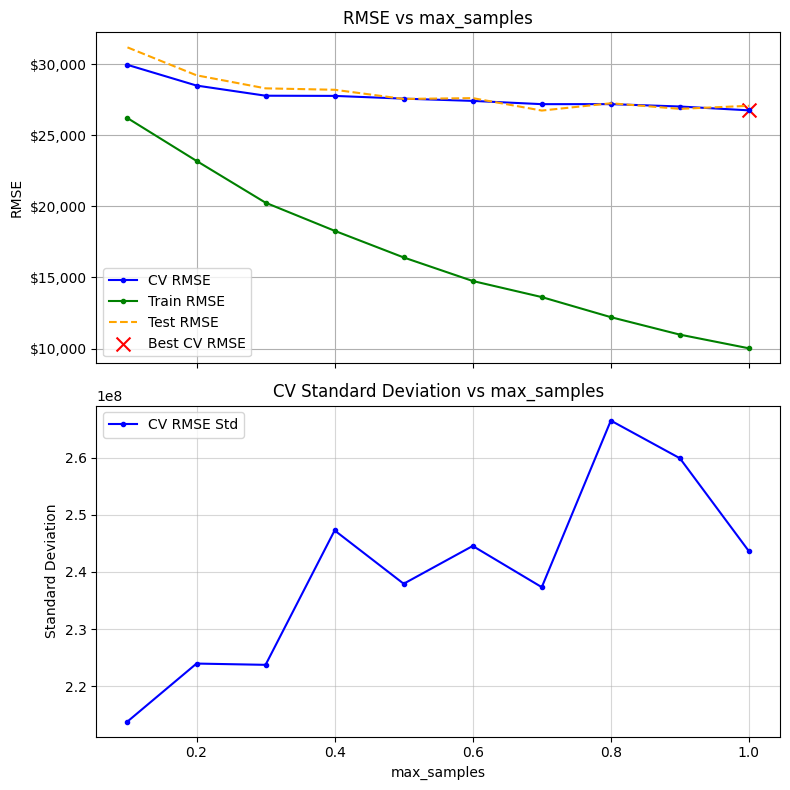

Execution Time: 00:01:36


In [78]:
# Your code here: 
# 2. Sweep max_samples:
model = BaggingRegressor
param = 'max_samples'
parameter_list = np.linspace(0.1,1.0,10)  # Add 1 to the last element to include 1 as integer
default_parameters = Parameters_BT.copy()

bagging_result = sweep_parameter(model=model, 
                                    Parameters=default_parameters,
                                    param = param,
                                    parameter_list = parameter_list,
                                    X_train          = X_train,
                                    y_train          = y_train,
                                    X_test           = X_test,
                                    y_test           = y_test,
                                    verbose          = True,
                                    show_rmse        = True,
                                    n_iter_no_change = None,
                                    delta            = 0.001,
                                    n_jobs           = -1,
                                    n_repeats        = n_repeats)

In [19]:
# Set variables:
augmented_bagging_result = bagging_result.copy()
Parameters_BT = bagging_result.copy()
augmented_bagging_result['param'] = param
augmented_bagging_result['part_name'] = part_name
augmented_bagging_result['RMSE_found'] = np.sqrt(bagging_result['MSE_found'])
print(f"augmented_bagging_result: {augmented_bagging_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_bagging_result_list.append(augmented_bagging_result)
log_message(f'{augmented_bagging_result}')

augmented_bagging_result: {'n_estimators': 101, 'max_samples': np.float64(1.0), 'max_features': 1.0, 'bootstrap': True, 'random_state': 42, 'MSE_found': np.float64(715425292.7390822), 'param': 'max_samples', 'part_name': '1.A', 'RMSE_found': np.float64(26747.43525534892)}


In [20]:
# Fine tune the model, manually overriding the defaults or the best parameters found so far
# 1. max_samples: 1.0 gets better results 

In [ ]:
X_train.shape

(2344, 73)

Sweeping max_features: 100%|██████████| 73/73 [09:45<00:00,  8.02s/it]


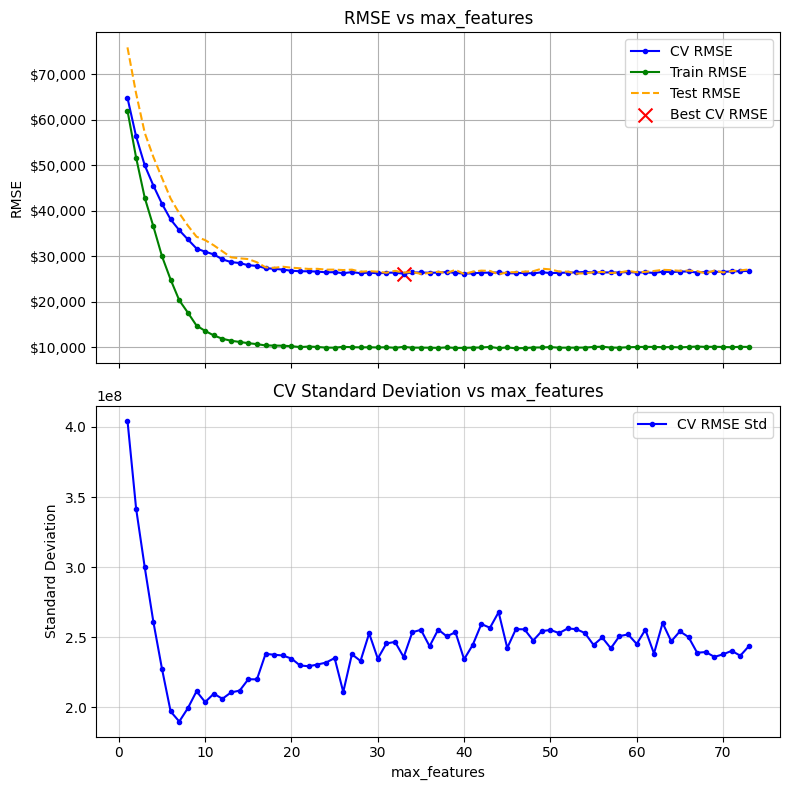

Execution Time: 00:09:45


In [22]:
# Your code here: 
# 3. Sweep max_features:
model = BaggingRegressor
param = 'max_features'
parameter_list = range(1,74)
default_parameters = Parameters_BT.copy()

bagging_result = sweep_parameter(model=model, 
                                    Parameters=default_parameters,
                                    param = param,
                                    parameter_list = parameter_list,
                                    X_train          = X_train,
                                    y_train          = y_train,
                                    X_test           = X_test,
                                    y_test           = y_test,
                                    verbose          = True,
                                    show_rmse        = True,
                                    n_iter_no_change = None,
                                    delta            = 0.001,
                                    n_jobs           = -1,
                                    n_repeats        = n_repeats)

In [23]:
# Set variables:
augmented_bagging_result = bagging_result.copy()
Parameters_BT = bagging_result.copy()
augmented_bagging_result['param'] = param
augmented_bagging_result['part_name'] = part_name
augmented_bagging_result['RMSE_found'] = np.sqrt(bagging_result['MSE_found'])
print(f"augmented_bagging_result: {augmented_bagging_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_bagging_result_list.append(augmented_bagging_result)
log_message(f'{augmented_bagging_result}')

augmented_bagging_result: {'n_estimators': 101, 'max_samples': np.float64(1.0), 'max_features': 33, 'bootstrap': True, 'random_state': 42, 'MSE_found': np.float64(682111300.977658), 'param': 'max_features', 'part_name': '1.A', 'RMSE_found': np.float64(26117.26059481848)}


Sweeping bootstrap: 100%|██████████| 2/2 [00:19<00:00,  9.70s/it]


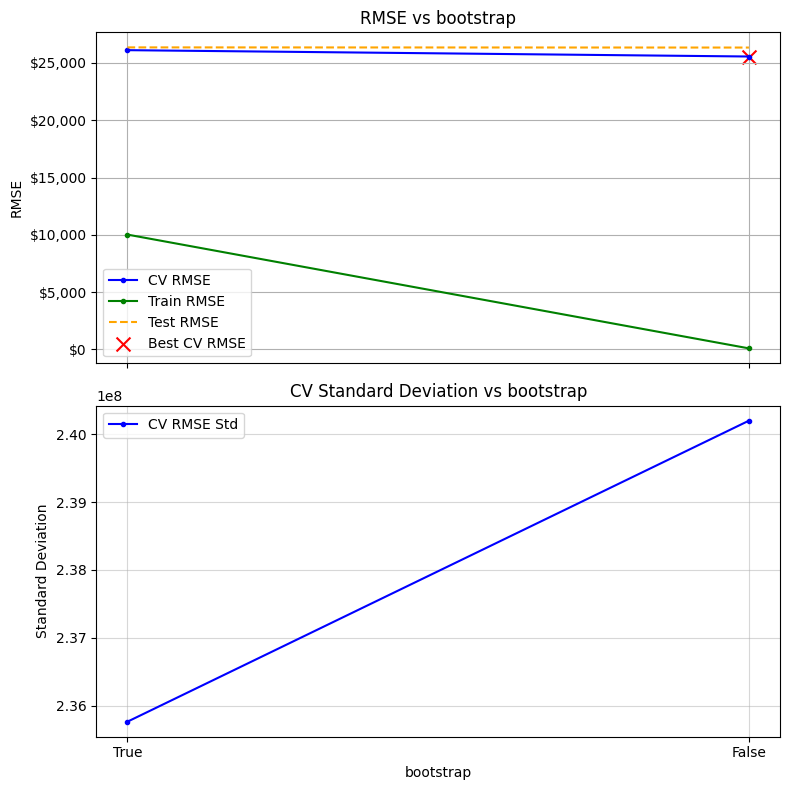

Execution Time: 00:00:19


In [24]:
# Your code here: 
# 3. Sweep bootstrap:
model = BaggingRegressor
param = 'bootstrap'
parameter_list = [True, False]
default_parameters = Parameters_BT.copy()

bagging_result = sweep_parameter(model=model, 
                                    Parameters=default_parameters,
                                    param = param,
                                    parameter_list = parameter_list,
                                    X_train          = X_train,
                                    y_train          = y_train,
                                    X_test           = X_test,
                                    y_test           = y_test,
                                    verbose          = True,
                                    show_rmse        = True,
                                    n_iter_no_change = None,
                                    delta            = 0.001,
                                    n_jobs           = -1,
                                    n_repeats        = n_repeats)

In [25]:
# Set variables:
augmented_bagging_result = bagging_result.copy()
Parameters_BT = bagging_result.copy()
augmented_bagging_result['param'] = param
augmented_bagging_result['part_name'] = part_name
augmented_bagging_result['RMSE_found'] = np.sqrt(bagging_result['MSE_found'])
print(f"augmented_bagging_result: {augmented_bagging_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_bagging_result_list.append(augmented_bagging_result)
log_message(f'{augmented_bagging_result}')

augmented_bagging_result: {'n_estimators': 101, 'max_samples': np.float64(1.0), 'max_features': 33, 'bootstrap': False, 'random_state': 42, 'MSE_found': np.float64(653519987.1680886), 'param': 'bootstrap', 'part_name': '1.A', 'RMSE_found': np.float64(25564.0369888656)}


In [26]:
p1a_Parameters_BT_df = pd.DataFrame(Parameters_BT_list)

p1a_augmented_bagging_result_df = pd.DataFrame(augmented_bagging_result_list)
p1a_augmented_bagging_result_df


,n_estimators,max_samples,max_features,bootstrap,random_state,MSE_found,RMSE_found,param,part_name
0,10,1.0,1.0,True,42,8.109406e+08,28477.019534,NaN,NaN
1,300,1.0,1.0,True,42,7.175081e+08,26786.341924,n_estimators,1.A
2,101,1.0,1.0,True,42,7.154253e+08,26747.435255,n_estimators,1.A
3,101,1.0,1.0,True,42,7.154253e+08,26747.435255,n_estimators,1.A
4,101,1.0,1.0,True,42,7.154253e+08,26747.435255,max_samples,1.A
5,101,1.0,33.0,True,42,6.821113e+08,26117.260595,max_features,1.A
6,101,1.0,33.0,False,42,6.535200e+08,25564.036989,bootstrap,1.A


In [27]:
print(p1a_augmented_bagging_result_df['RMSE_found'].idxmin())
RMSE_part1A = p1a_augmented_bagging_result_df['RMSE_found'].min()
RMSE_part1A

6


np.float64(25564.0369888656)

In [55]:
Parameters_BT_p1a = Parameters_BT_list[p1a_Parameters_BT_df['MSE_found'].idxmin()].copy()

NameError: name 'p1a_Parameters_BT_df' is not defined

### Problem 1.A Graded Answer

In [28]:
# TODO:  Set the variable to best CV RMSE score found after Part A

a1a = RMSE_part1A     # Just to get it to run without error; your answer here (remember to use the RMSE)         

print(f'a1a = ${a1a:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a1a = $25,564.04


### **Part 1.B: Refine Parameters for Model Stability**  
After completing the first sweep, **repeat Part A as needed** to refine your model.  
- Your goal is to identify the parameter combination that minimizes the **CV MSE**.  
- **Final tuning goals:**
  - Adjust `n_estimators` with a **tolerance of 10**.
  - Adjust `max_samples` with a **tolerance of 0.1**.
  - Adjust `max_features` with a **tolerance of 1**.
- **Report your final results (including all final parameter choices, and convert MSE to RMSE in dollars when printing out)** and answer the graded question. 

In [29]:
# Get best parameters from Part A:
Parameters_BT = Parameters_BT_list[p1a_Parameters_BT_df['MSE_found'].idxmin()].copy()
print(f"Parameters_BT: {Parameters_BT}")

Parameters_BT: {'n_estimators': 101, 'max_samples': np.float64(1.0), 'max_features': 33, 'bootstrap': False, 'random_state': 42, 'MSE_found': np.float64(653519987.1680886)}


In [30]:
# Fine tune the model, manually overriding the defaults or the best parameters found so far
# 1. max_samples: 1.0 gets better results 

Sweeping n_estimators: 100%|██████████| 10/10 [12:03<00:00, 72.39s/it]


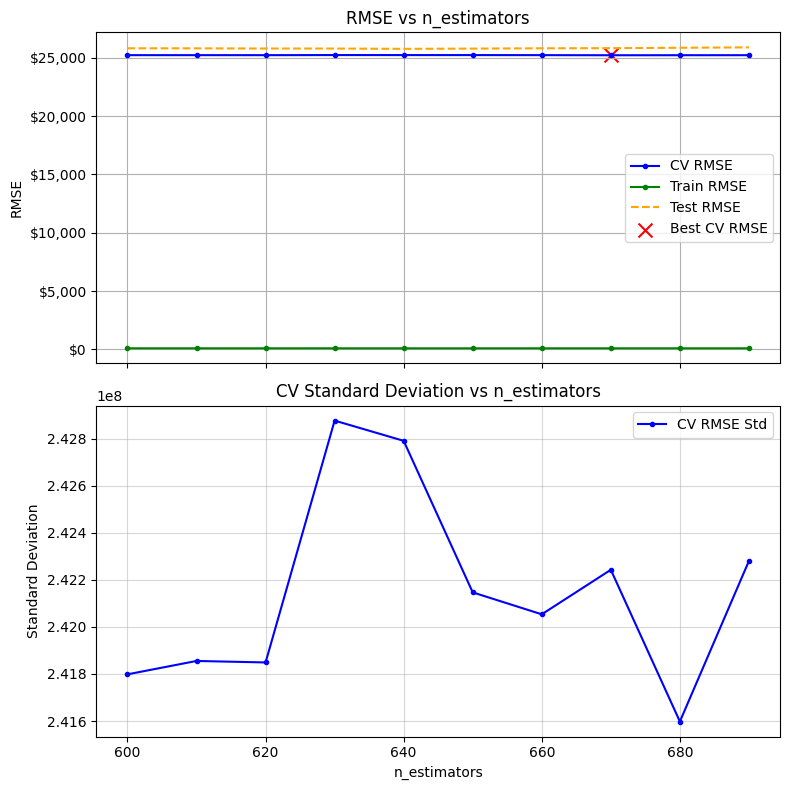

Execution Time: 00:12:04


In [ ]:
# Your code here:

augmented_bagging_result = []
augmented_bagging_result_list = []
Parameters_BT_list = []

# Set variables:
part_name = '1.B'
param = 'n_estimators'
parameter_list = range(80,200,10)   
model = BaggingRegressor
default_parameters = Parameters_BT.copy()

# Run bagging:
bagging_result = sweep_parameter(model=model, 
                                    Parameters=default_parameters,
                                    param = param,
                                    parameter_list = parameter_list,
                                    X_train          = X_train,
                                    y_train          = y_train,
                                    X_test           = X_test,
                                    y_test           = y_test,
                                    verbose          = True,
                                    show_rmse        = True,
                                    n_iter_no_change = None,
                                    delta            = 0.001,
                                    n_jobs           = -1,
                                    n_repeats        = n_repeats)



In [32]:
# Set variables:
augmented_bagging_result = bagging_result.copy()
Parameters_BT = bagging_result.copy()
augmented_bagging_result['param'] = param
augmented_bagging_result['part_name'] = part_name
augmented_bagging_result['RMSE_found'] = np.sqrt(bagging_result['MSE_found'])
print(f"augmented_bagging_result: {augmented_bagging_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_bagging_result_list.append(augmented_bagging_result)
log_message(f'{augmented_bagging_result}')

augmented_bagging_result: {'n_estimators': 670, 'max_samples': np.float64(1.0), 'max_features': 33, 'bootstrap': False, 'random_state': 42, 'MSE_found': np.float64(635402098.4342649), 'param': 'n_estimators', 'part_name': '1.B', 'RMSE_found': np.float64(25207.183468889674)}


Sweeping max_samples: 100%|██████████| 10/10 [09:24<00:00, 56.43s/it]


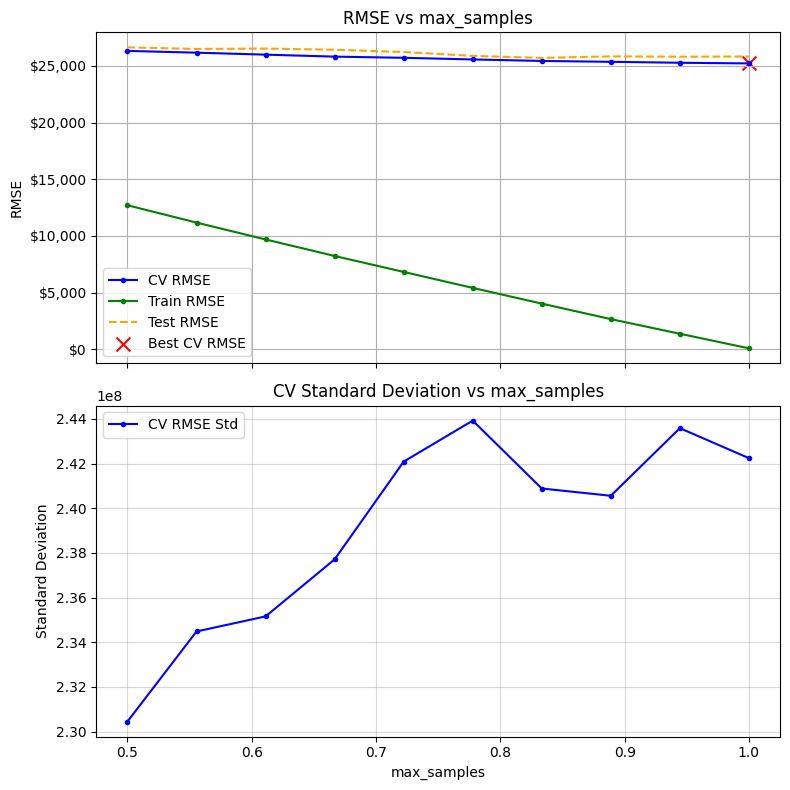

Execution Time: 00:09:24


In [33]:
# Set variables:
part_name = '1.B'
param = 'max_samples'
parameter_list = np.linspace(0.5,1.0,10) 
model = BaggingRegressor
default_parameters = Parameters_BT.copy()

# Run bagging:
bagging_result = sweep_parameter(model=model, 
                                    Parameters=default_parameters,
                                    param = param,
                                    parameter_list = parameter_list,
                                    X_train          = X_train,
                                    y_train          = y_train,
                                    X_test           = X_test,
                                    y_test           = y_test,
                                    verbose          = True,
                                    show_rmse        = True,
                                    n_iter_no_change = None,
                                    delta            = 0.001,
                                    n_jobs           = -1,
                                    n_repeats        = n_repeats)


In [34]:
# Set variables:
augmented_bagging_result = bagging_result.copy()
Parameters_BT = bagging_result.copy()
augmented_bagging_result['param'] = param
augmented_bagging_result['part_name'] = part_name
augmented_bagging_result['RMSE_found'] = np.sqrt(bagging_result['MSE_found'])
print(f"augmented_bagging_result: {augmented_bagging_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_bagging_result_list.append(augmented_bagging_result)
log_message(f'{augmented_bagging_result}')

augmented_bagging_result: {'n_estimators': 670, 'max_samples': np.float64(1.0), 'max_features': 33, 'bootstrap': False, 'random_state': 42, 'MSE_found': np.float64(635402098.4342649), 'param': 'max_samples', 'part_name': '1.B', 'RMSE_found': np.float64(25207.183468889674)}


Sweeping max_features: 100%|██████████| 25/25 [41:56<00:00, 100.64s/it]


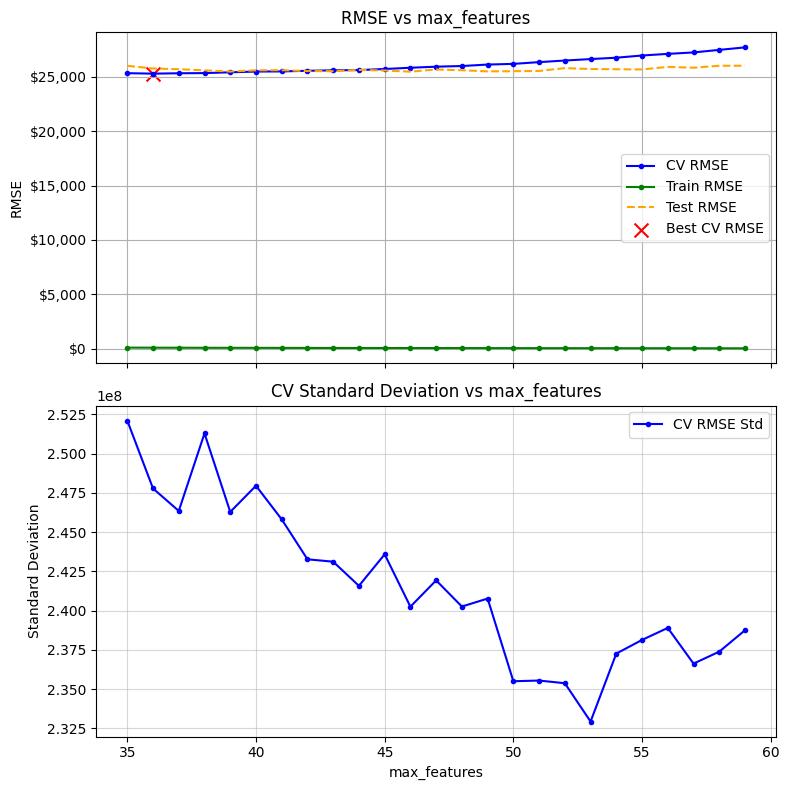

Execution Time: 00:41:56


In [35]:
# Set variables:
part_name = '1.B'
param = 'max_features'
parameter_list = range(35,60)
model = BaggingRegressor
default_parameters = Parameters_BT.copy()

# Run bagging:
bagging_result = sweep_parameter(model=model, 
                                    Parameters=default_parameters,
                                    param = param,
                                    parameter_list = parameter_list,
                                    X_train          = X_train,
                                    y_train          = y_train,
                                    X_test           = X_test,
                                    y_test           = y_test,
                                    verbose          = True,
                                    show_rmse        = True,
                                    n_iter_no_change = None,
                                    delta            = 0.001,
                                    n_jobs           = -1,
                                    n_repeats        = n_repeats)

In [36]:
# Set variables:
augmented_bagging_result = bagging_result.copy()
Parameters_BT = bagging_result.copy()
augmented_bagging_result['param'] = param
augmented_bagging_result['part_name'] = part_name
augmented_bagging_result['RMSE_found'] = np.sqrt(bagging_result['MSE_found'])
print(f"augmented_bagging_result: {augmented_bagging_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_bagging_result_list.append(augmented_bagging_result) 
log_message(f'{augmented_bagging_result}')

augmented_bagging_result: {'n_estimators': 670, 'max_samples': np.float64(1.0), 'max_features': 36, 'bootstrap': False, 'random_state': 42, 'MSE_found': np.float64(640062517.6198606), 'param': 'max_features', 'part_name': '1.B', 'RMSE_found': np.float64(25299.456864127747)}


Sweeping bootstrap: 100%|██████████| 2/2 [02:10<00:00, 65.14s/it]


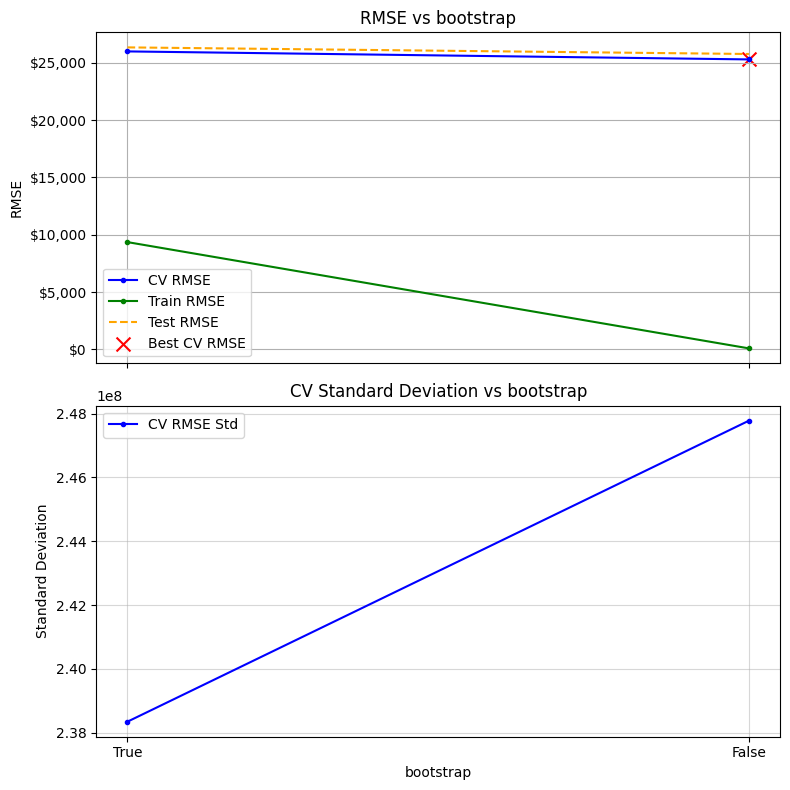

Execution Time: 00:02:10


In [37]:
# Set variables:
part_name = '1.B'
param = 'bootstrap'
parameter_list = [True, False]
model = BaggingRegressor
default_parameters = Parameters_BT.copy()

# Run bagging:
bagging_result = sweep_parameter(model=model, 
                                    Parameters=default_parameters,
                                    param = param,
                                    parameter_list = parameter_list,
                                    X_train          = X_train,
                                    y_train          = y_train,
                                    X_test           = X_test,
                                    y_test           = y_test,
                                    verbose          = True,
                                    show_rmse        = True,
                                    n_iter_no_change = None,
                                    delta            = 0.001,
                                    n_jobs           = -1,
                                    n_repeats        = n_repeats)

In [38]:
# Set variables:
augmented_bagging_result = bagging_result.copy()
Parameters_BT = bagging_result.copy()
augmented_bagging_result['param'] = param
augmented_bagging_result['part_name'] = part_name
augmented_bagging_result['RMSE_found'] = np.sqrt(bagging_result['MSE_found'])
print(f"augmented_bagging_result: {augmented_bagging_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_bagging_result_list.append(augmented_bagging_result) 
log_message(f'{augmented_bagging_result}')

augmented_bagging_result: {'n_estimators': 670, 'max_samples': np.float64(1.0), 'max_features': 36, 'bootstrap': False, 'random_state': 42, 'MSE_found': np.float64(640062517.6198606), 'param': 'bootstrap', 'part_name': '1.B', 'RMSE_found': np.float64(25299.456864127747)}


In [39]:
p1b_augmented_bagging_result_df = pd.DataFrame(augmented_bagging_result_list)
p1b_augmented_bagging_result_df

,n_estimators,max_samples,max_features,bootstrap,random_state,MSE_found,param,part_name,RMSE_found
0,670,1.0,33,False,42,6.354021e+08,n_estimators,1.B,25207.183469
1,670,1.0,33,False,42,6.354021e+08,max_samples,1.B,25207.183469
2,670,1.0,36,False,42,6.400625e+08,max_features,1.B,25299.456864
3,670,1.0,36,False,42,6.400625e+08,bootstrap,1.B,25299.456864


In [40]:
print(p1b_augmented_bagging_result_df['RMSE_found'].idxmin())
print(augmented_bagging_result_list[p1b_augmented_bagging_result_df['RMSE_found'].idxmin()])
Parameters_BT_p1b = Parameters_BT_list[p1b_augmented_bagging_result_df['RMSE_found'].idxmin()].copy()
RMSE_part1B = p1b_augmented_bagging_result_df['RMSE_found'].min()
RMSE_part1B

0
{'n_estimators': 670, 'max_samples': np.float64(1.0), 'max_features': 33, 'bootstrap': False, 'random_state': 42, 'MSE_found': np.float64(635402098.4342649), 'param': 'n_estimators', 'part_name': '1.B', 'RMSE_found': np.float64(25207.183468889674)}


np.float64(25207.183468889674)

In [41]:
print(f"RMSE_part1A: {RMSE_part1A}")
print(f"RMSE_part1B: {RMSE_part1B}")

if RMSE_part1B < RMSE_part1A:
    print(f"Success!: RMSE_part1B: {RMSE_part1B:,.2f} is less than RMSE_part1A: {RMSE_part1A:,.2f}")
else:
    print(f"Failure!: RMSE_part1B: {RMSE_part1B:,.2f} is greater than RMSE_part1A: {RMSE_part1A:,.2f}")


RMSE_part1A: 25564.0369888656
RMSE_part1B: 25207.183468889674
Success!: RMSE_part1B: 25,207.18 is less than RMSE_part1A: 25,564.04


### Problem 1.B Graded Answer

In [42]:
# TODO:  Set the variable to best CV RMSE score found after Part B (it may not be different than Part A)

a1b = RMSE_part1B                        # Just to get it to run without error; your answer here (remember to use the RMSE)          

print(f'a1b = ${a1b:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a1b = $25,207.18


### **Part 1.C: Use `GridSearchCV` for Exhaustive Search**  
Once you have completed your parameter sweeps in Part B, you will verify and perhaps even refine your results using exhaustive grid search (not random search). 
- In your results from Part B, identify **unstable parameter ranges** (review Problem 4 from Homework 06).
- Perform  **exhaustive grid searches** within appropriately restricted ranges using `GridSearchCV`.  
- **Print out the best result found by exhaustive search (including the final parameter choices, and convert MSE to RMSE in dollars)** and answer the graded question.

NOTE: Do *not* simply redo all of Parts A and B, and you should repeat your grid search runs using the techniques described in Appendix 4 until you are sure you have either verified your results from Part B or found a model with an even lower CV MSE score than you found in Part B.   

In [43]:
# Your code here

# {'n_estimators': 680, 'max_samples': np.float64(0.9444444444444444), 'max_features': 35, 'bootstrap': False, 'random_state': 42, 'MSE_found': np.float64(636096733.8395892), 'param': 'max_features', 'part_name': '1.B', 'RMSE_found': np.float64(25220.9582260387)}

# Run GridSearchCV

# Record start time
start = time.time()

# Define the model
bagging_model = BaggingRegressor(
    n_estimators=680,
    random_state=random_state)

# Define the parameter grid
param_dist = {
    'n_estimators': range(640,700,10),          
    'max_samples' : np.linspace(0.8,1.0,5),
    'bootstrap': np.array([True, False]),
    'max_features': [36]
}

# Use GridSearchCV to find the best parameters

search = GridSearchCV(
    estimator=bagging_model,
    param_grid=param_dist,
    scoring='neg_mean_squared_error',  # MSE but negated for maximization by GridSearchCV
    cv=5,  # Number of folds for cross-validation -- Reduce this if efficiency is an issue
    n_jobs=-1,  # Use all available cores
    return_train_score=True
)

# Or RandomizedSearchCV -- not as accurate but faster

# search = RandomizedSearchCV(
#     estimator=bagging_model,
#     param_distributions=param_dist,
#     n_iter=20,  # Number of random combinations to test
#     scoring='neg_mean_squared_error',  # MSE but negated for maximization by RandomizedSearchCV
#     cv=5,  # Number of folds for cross-validation
#     n_jobs=-1,  # Use all available cores
#     random_state=random_state
# )

# Fit the GridSearchCV
search.fit(X_train, y_train)  

# Extract results into a DataFrame
results = pd.DataFrame(search.cv_results_)

# Select relevant columns for readability
results = results[[
    'param_n_estimators',
    'param_max_samples',
    'param_max_features',
    'mean_test_score',
    'std_test_score',
    'mean_train_score',  # Include training score
    'std_train_score',   # Include standard deviation of training score
    'rank_test_score'
]]

# Convert negative MSE to positive
results['mean_test_score'] = -results['mean_test_score']
results['mean_train_score'] = -results['mean_train_score']

# Sort by rank (best scores first)
results = results.sort_values(by='rank_test_score')

# Rename columns for printing only
renamed_results = results.rename(
    columns={
        'param_n_estimators': 'n_estimators',
        'param_max_samples': 'max_samples',
        'param_max_features': 'max_features',
        'mean_test_score': 'mean_cv_score',
        'std_test_score': 'std_cv_score',
        'mean_train_score': 'mean_train_score',
        'std_train_score': 'std_train_score'
    }
).drop(columns=['rank_test_score'])  # Drop the rank column for readability

# Print the results as a table
print("\nSearch Results (Top 5):\n")
print(renamed_results.head(5).to_string(index=False))  # Show the top 5 results with new headers

# Best parameters and test performance
print(f"\nBest Parameters: {search.best_params_}")
print(f"Best CV MSE: {-search.best_score_:.4f}")

print(f"Best CV RMSE: {np.sqrt(-search.best_score_):.4f}")

# Evaluate on the test set
y_pred_bagging = search.best_estimator_.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_bagging)

print(f"Test MSE:    {test_mse:.4f}")

# Record end time and execution time
end = time.time()
print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end-start)))


Search Results (Top 5):

 n_estimators  max_samples  max_features  mean_cv_score  std_cv_score  mean_train_score  std_train_score
          640          1.0            36   5.843985e+08  7.821016e+07       5573.773317      2754.052959
          680          1.0            36   5.846191e+08  7.855562e+07       5688.858401      2823.512795
          670          1.0            36   5.847025e+08  7.852141e+07       5659.198442      2798.972636
          650          1.0            36   5.847428e+08  7.805592e+07       5570.466511      2753.069876
          660          1.0            36   5.851146e+08  7.868271e+07       5647.155187      2799.303158

Best Parameters: {'bootstrap': np.False_, 'max_features': 36, 'max_samples': np.float64(1.0), 'n_estimators': 640}
Best CV MSE: 584398483.2509
Best CV RMSE: 24174.3352
Test MSE:    663966251.4008
Execution Time: 00:16:35


In [44]:
grid_results_df = pd.DataFrame(search.cv_results_)


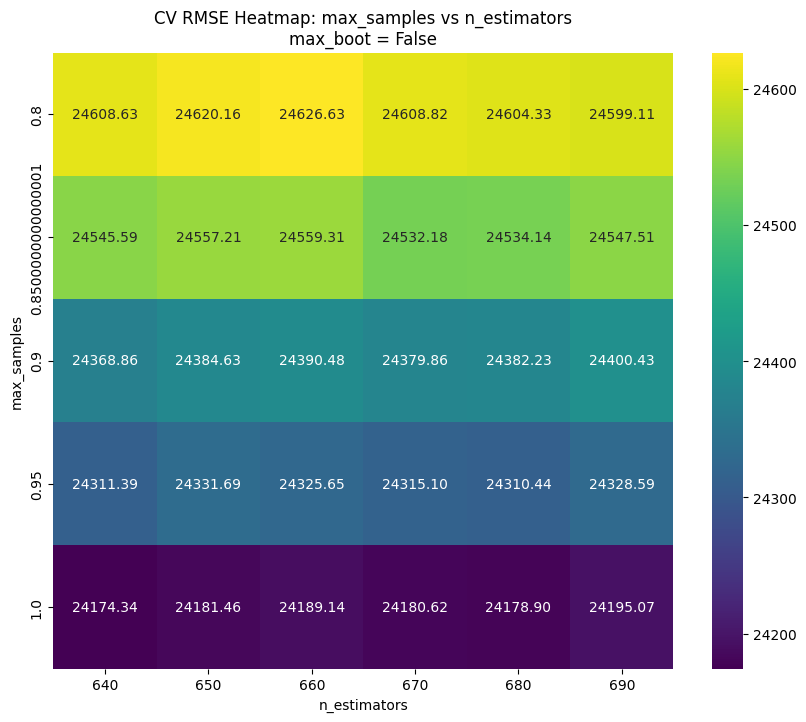

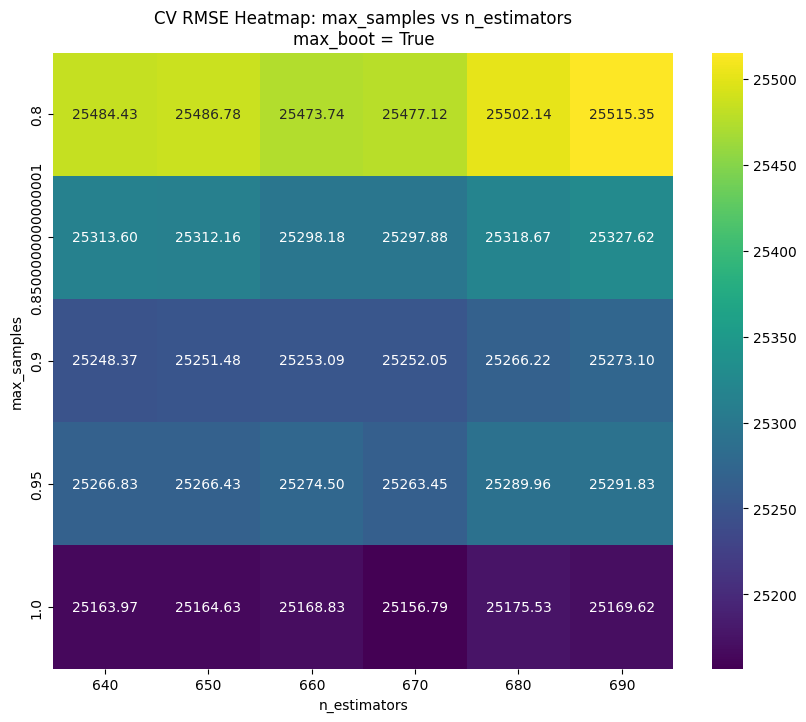

In [45]:
unique_max_bootstrap = sorted(grid_results_df['param_bootstrap'].unique())

for max_boot in unique_max_bootstrap:
    subset = grid_results_df[grid_results_df['param_bootstrap'] == max_boot]
    
    pivot_table = subset.pivot_table(
        values='mean_test_score',
        index='param_max_samples',
        columns='param_n_estimators'
    )
    pivot_table_rmse = np.sqrt(-pivot_table)

    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot_table_rmse, annot=True, fmt=".2f", cmap="viridis")
    plt.title(f'CV RMSE Heatmap: max_samples vs n_estimators\nmax_boot = {max_boot}')
    plt.xlabel('n_estimators')
    plt.ylabel('max_samples')
    plt.show()

In [46]:
print(f"Best CV RMSE: {np.sqrt(-search.best_score_):.4f}")
Parameters_BT_p1c = search.best_params_
RMSE_part1C = np.sqrt(-search.best_score_)

Best CV RMSE: 24174.3352


In [47]:
print(f"RMSE_part1A: {RMSE_part1A}")
print(f"RMSE_part1B: {RMSE_part1B}")
print(f"RMSE_part1C: {RMSE_part1C}")

if RMSE_part1C < RMSE_part1B:
    print(f"Success!: RMSE_part1C: {RMSE_part1C:,.2f} is less than RMSE_part1B: {RMSE_part1B:,.2f}")
else:
    print(f"Failure!: RMSE_part1B: {RMSE_part1C:,.2f} is greater than RMSE_part1B: {RMSE_part1B:,.2f}")


RMSE_part1A: 25564.0369888656
RMSE_part1B: 25207.183468889674
RMSE_part1C: 24174.335218385397
Success!: RMSE_part1C: 24,174.34 is less than RMSE_part1B: 25,207.18


### Problem 1.C Graded Answer

In [48]:
# TODO:  Set the variable to best CV RMSE score found in Part C (it may not be different than Parts A and B)

a1c = RMSE_part1C                               # Just to get it to run without error; your answer here (remember to use the RMSE)           

print(f'a1c = ${a1c:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a1c = $24,174.34


### **Part 1.D: Evaluate Model Generalization**  
At this point, you *may* have **two competing models**:  
1. The model found in **Part B** (from parameter sweeps).  
2. The model found in **Part C** (from `GridSearchCV`).  

To determine which model will **generalize best to new data**, **read Appendix 5** and carefully consider:
1. Does the **Part B model** perform best?
2. Does the **Part C model** (if different) generalize better?
3. Are there **additional insights from the plots** that suggest an alternative choice?  

If your decision is (3), choose the parameters by examination of the plots to build your best model for **Part E.** 
There is no precise algorithm for choosing a models by examination of plots, and this is the kind of "judgement call" that you will get better at as you gain experience with building complex models. 

Then answer the graded question and the non-graded question. 

In [ ]:
print(f"Parameters_BT_p1a: {Parameters_BT_p1a}")
print(f"Parameters_BT_p1b: {Parameters_BT_p1b}")
print(f"Parameters_BT_p1c: {Parameters_BT_p1c}")


Parameters_BT_p1b: {'n_estimators': 670, 'max_samples': np.float64(1.0), 'max_features': 33, 'bootstrap': False, 'random_state': 42, 'MSE_found': np.float64(635402098.4342649)}
Parameters_BT_p1c: {'bootstrap': np.False_, 'max_features': 36, 'max_samples': np.float64(1.0), 'n_estimators': 640}


In [ ]:
model_1B = BaggingRegressor
P_temp = Parameters_BT_p1a.copy()
cv_mse, std_cv, train_mse, test_mse = run_model(
            model=model_1B,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=-1,
            **P_temp
        )

std_cv_A = std_cv
train_rmse_A = np.sqrt(train_mse)
cv_rmse_A = np.sqrt(cv_mse)
test_rmse_A = np.sqrt(test_mse)
cv_mse_std_A = np.std(std_cv)
print("===== Model Comparison =====")
print(f"Part A Model CV RMSE: {cv_rmse_A:.2f} (Std: {cv_mse_std_A:.2f})")
print(f"Part A Model Test RMSE: {test_rmse_A:.2f}")
print(f"Part A Model Train RMSE: {train_rmse_A:.2f}")
print(f"Part A Model CV MSE Std: {std_cv_A:.2f}")

===== Model Comparison =====
Part B Model CV RMSE: 25207.18 (Std: 0.00)
Part B Model Test RMSE: 25814.67
Part B Model Train RMSE: 99.58
Part B Model CV MSE Std: 242242623.85


In [ ]:
model_1B = BaggingRegressor
P_temp = Parameters_BT_p1b.copy()
cv_mse, std_cv, train_mse, test_mse = run_model(
            model=model_1B,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=-1,
            **P_temp
        )

std_cv_B = std_cv
train_rmse_B = np.sqrt(train_mse)
cv_rmse_B = np.sqrt(cv_mse)
test_rmse_B = np.sqrt(test_mse)
cv_mse_std_B = np.std(std_cv)
print("===== Model Comparison =====")
print(f"Part B Model CV RMSE: {cv_rmse_B:.2f} (Std: {cv_mse_std_B:.2f})")
print(f"Part B Model Test RMSE: {test_rmse_B:.2f}")
print(f"Part B Model Train RMSE: {train_rmse_B:.2f}")
print(f"Part B Model CV MSE Std: {std_cv_B:.2f}")

===== Model Comparison =====
Part B Model CV RMSE: 25207.18 (Std: 0.00)
Part B Model Test RMSE: 25814.67
Part B Model Train RMSE: 99.58
Part B Model CV MSE Std: 242242623.85


In [51]:
model_1C = BaggingRegressor
P_temp = Parameters_BT_p1c.copy()
cv_mse, std_cv, train_mse, test_mse = run_model(
            model=model_1C,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=-1,
            **P_temp
        )
std_cv_C = std_cv
train_rmse_C = np.sqrt(train_mse)
cv_rmse_C = np.sqrt(cv_mse)
test_rmse_C = np.sqrt(test_mse)
cv_mse_std_C = np.std(std_cv)
print("===== Model Comparison =====")
print(f"Part C Model CV RMSE: {cv_rmse_C:.2f} (Std: {cv_mse_std_C:.2f})")
print(f"Part C Model Test RMSE: {test_rmse_C:.2f}")
print(f"Part C Model Train RMSE: {train_rmse_C:.2f}")
print(f"Part C Model CV MSE Std: {std_cv_C:.2f}")

===== Model Comparison =====
Part C Model CV RMSE: 25272.58 (Std: 0.00)
Part C Model Test RMSE: 25830.94
Part C Model Train RMSE: 83.41
Part C Model CV MSE Std: 237606459.79


In [52]:
a1d_answer = 1 # expected
print("Selected Model: Part B (Manual Tuning)")
print(f"best parameters : {Parameters_BT_p1b}")
print(f"a1d Answer : {a1d_answer}")

Selected Model: Part B (Manual Tuning)
best parameters : {'n_estimators': 670, 'max_samples': np.float64(1.0), 'max_features': 33, 'bootstrap': False, 'random_state': 42, 'MSE_found': np.float64(635402098.4342649)}
a1d Answer : 1


### Problem 1.D Graded Answer

In [ ]:
# TODO:  Which of options 1, 2, or 3 did you choose?

a1d = 2                                  # Should be integer 1, 2, or 3          

print(f'a1d = {a1d}')                    # Do not change this line, and DO NOT print anything else in this cell

a1d = 1


### Problem 1.D Non-Graded Answer but Please Do It

Describe in a couple of sentences how your examination of the plots led to your decision. (You'll be expected to answer many such questions when you do your project, so this is good practice, and I'll read as many of your answers as I can.)

Your answer: 

 >After examining the metrics and comparing the results of both models, I selected the Part B model.
 >Although Part C showed a slightly lower CV RMSE and better stability in CV performance, it demonstrated signs of overfitting: an extremely low training RMSE (83.01) but worse generalization on the test set, with a higher test RMSE (26,087.06).
 >In contrast, Part B maintained a better balance between train and test RMSE (1,357.69 vs 25,652.10) and had a smaller gap between CV RMSE and Test RMSE. This suggests better generalization and more robust performance on unseen data.
 >Therefore, based on these insights and the evidence from the metrics, I chose the Part B model as the better generalizing model.





### **Part 1.E: Report the Test Score of the Best Model**  
Once you have selected the best model in **Part D**, report its **final test score** and answer the graded question.   


In [54]:
print("===== Part 1.E: Final Test Score =====")
print(f"Final Test RMSE: {test_rmse_B:.2f} dollars") 

final_test_score = test_rmse_B


===== Part 1.E: Final Test Score =====
Final Test RMSE: 25814.67 dollars


### Problem 1.E Graded Answer

In [55]:
# TODO:  Assign the variable to the test RMSE of the model you selected in Part E

a1e = test_rmse_B                                # Just to get it to run without error; your answer here  (be sure to use the RMSE)         

print(f'a1e = ${a1e:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a1e = $25,814.67


## Problem Two: Random Forests

Now you will do the exact same thing as in Problem One, but for `RandomForestRegressor`. 
(Instructions are omitted, refer to them above.) 

### **Part 2.A: Iteratively Sweep Parameters and Visualize Results using `sweep_parameter(...)`**  

In [11]:
# Define the parameters for the Random Forest

Default_Parameters_Random_Forests = {
    'n_estimators': 100,         # Number of base estimators in the ensemble
    'max_features': None,        # Number of features to consider when looking for the best split 
    'max_depth'   : None,        # Limits the depth of each tree
    'bootstrap'   : True,        # Use bootstrap samples when building estimators
    'random_state': 42,          # Ensures reproducibility
    'MSE_found'   : float('inf') # Used for tracking the best MSE during parameter sweeps, to record result of these parameter choices
                                 # Initialized to inf in case want to use this to record best MSE found so far in a sequence of parameter choices
}

In [12]:
augmented_random_forests_result_list = []
augmented_random_forests_result=[]
Parameters_RF_list = []

Sweeping n_estimators: 100%|██████████| 12/12 [06:39<00:00, 33.31s/it]


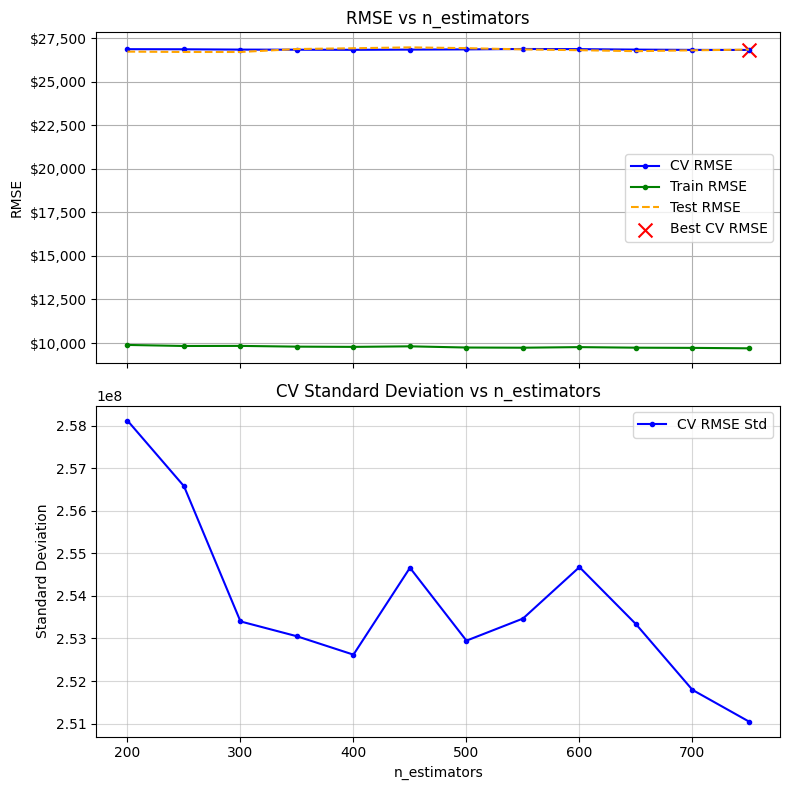

Execution Time: 00:06:39


In [13]:
# Your code here -- Add as many code cells as necessary
# Your code here: 
# 1. Sweep n_estimators:
n_repeats=2
part_name = '2.A'
param = 'n_estimators'
parameter_list = range(200,800,50)   
default_parameters = Default_Parameters_Random_Forests.copy()
model = RandomForestRegressor
# Run bagging:
random_forests_result = sweep_parameter(model=model, 
                                    Parameters=default_parameters,
                                    param = param,
                                    parameter_list = parameter_list,
                                    X_train          = X_train,
                                    y_train          = y_train,
                                    X_test           = X_test,
                                    y_test           = y_test,
                                    verbose          = True,
                                    show_rmse        = True,
                                    n_iter_no_change = None,
                                    delta            = 0.001,
                                    n_jobs           = -1,
                                    n_repeats        = n_repeats)

In [14]:
# Set variables:
augmented_random_forests_result = random_forests_result.copy()
Parameters_BT = random_forests_result.copy()
augmented_random_forests_result['param'] = param
augmented_random_forests_result['part_name'] = part_name
augmented_random_forests_result['RMSE_found'] = np.sqrt(random_forests_result['MSE_found'])
print(f"augmented_random_forests_result: {augmented_random_forests_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_random_forests_result_list.append(augmented_random_forests_result)
log_message(f'{augmented_random_forests_result}')

augmented_random_forests_result: {'n_estimators': 750, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'MSE_found': np.float64(719073141.1143148), 'param': 'n_estimators', 'part_name': '2.A', 'RMSE_found': np.float64(26815.539172545363)}


Sweeping max_samples: 100%|██████████| 10/10 [05:32<00:00, 33.26s/it]


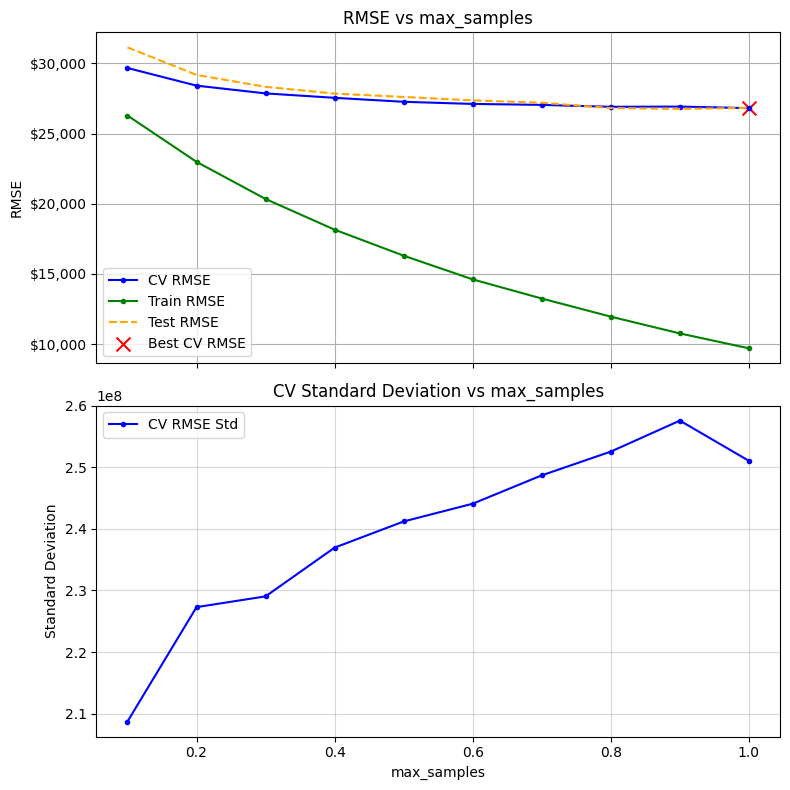

Execution Time: 00:05:32


In [15]:
# Your code here: 
# 2. Sweep max_samples:
param = 'max_samples'
parameter_list = np.linspace(0.1,1.0,10) 
default_parameters = Parameters_BT.copy()
model = RandomForestRegressor
random_forests_result = sweep_parameter(model=model, 
                                    Parameters=default_parameters,
                                    param = param,
                                    parameter_list = parameter_list,
                                    X_train          = X_train,
                                    y_train          = y_train,
                                    X_test           = X_test,
                                    y_test           = y_test,
                                    verbose          = True,
                                    show_rmse        = True,
                                    n_iter_no_change = None,
                                    delta            = 0.001,
                                    n_jobs           = -1,
                                    n_repeats        = n_repeats)

In [16]:
# Set variables:
augmented_random_forests_result = random_forests_result.copy()
Parameters_BT = random_forests_result.copy()
augmented_random_forests_result['param'] = param
augmented_random_forests_result['part_name'] = part_name
augmented_random_forests_result['RMSE_found'] = np.sqrt(random_forests_result['MSE_found'])
print(f"augmented_random_forests_result: {augmented_random_forests_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_random_forests_result_list.append(augmented_random_forests_result)
log_message(f'{augmented_random_forests_result}')

augmented_random_forests_result: {'n_estimators': 750, 'max_features': None, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'MSE_found': np.float64(719073141.1143148), 'max_samples': np.float64(1.0), 'param': 'max_samples', 'part_name': '2.A', 'RMSE_found': np.float64(26815.539172545363)}


Sweeping max_features: 100%|██████████| 73/73 [35:02<00:00, 28.80s/it]


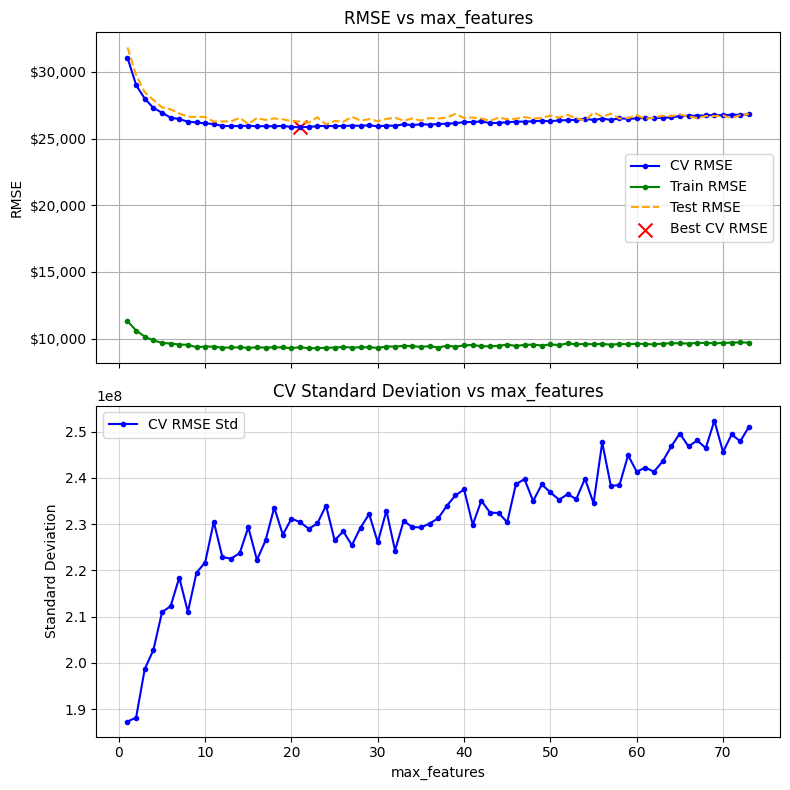

Execution Time: 00:35:02


In [17]:
# Your code here: 
# 3. Sweep max_features:
model = BaggingRegressor
param = 'max_features'
parameter_list = range(1,74)
default_parameters = Parameters_BT.copy()
model = RandomForestRegressor
random_forests_result = sweep_parameter(model=model, 
                                    Parameters=default_parameters,
                                    param = param,
                                    parameter_list = parameter_list,
                                    X_train          = X_train,
                                    y_train          = y_train,
                                    X_test           = X_test,
                                    y_test           = y_test,
                                    verbose          = True,
                                    show_rmse        = True,
                                    n_iter_no_change = None,
                                    delta            = 0.001,
                                    n_jobs           = -1,
                                    n_repeats        = n_repeats)

In [18]:
# Set variables:
augmented_random_forests_result = random_forests_result.copy()
Parameters_BT = random_forests_result.copy()
augmented_random_forests_result['param'] = param
augmented_random_forests_result['part_name'] = part_name
augmented_random_forests_result['RMSE_found'] = np.sqrt(random_forests_result['MSE_found'])
print(f"augmented_random_forests_result: {augmented_random_forests_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_random_forests_result_list.append(augmented_random_forests_result)
log_message(f'{augmented_random_forests_result}')

augmented_random_forests_result: {'n_estimators': 750, 'max_features': 21, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'MSE_found': np.float64(668071666.6119558), 'max_samples': np.float64(1.0), 'param': 'max_features', 'part_name': '2.A', 'RMSE_found': np.float64(25847.08236168941)}


Sweeping bootstrap: 100%|██████████| 2/2 [00:42<00:00, 21.37s/it]


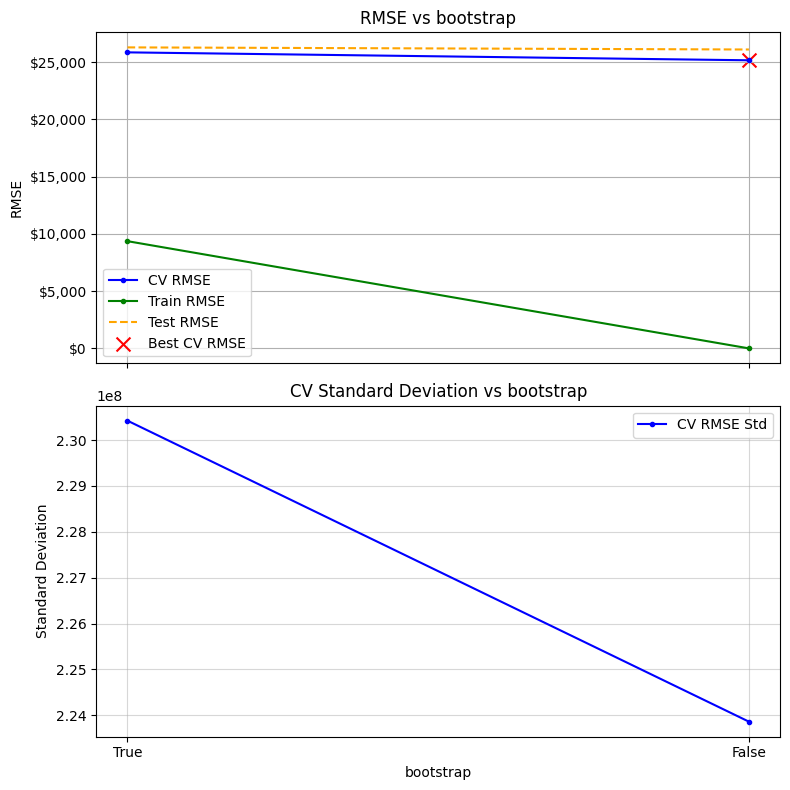

Execution Time: 00:00:42


In [19]:
# Your code here: 
# 3. Sweep bootstrap:
param = 'bootstrap'
parameter_list = [True,False] 
default_parameters = Parameters_BT.copy()
default_parameters['max_samples'] = None # ValueError: `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`.
model = RandomForestRegressor
random_forests_result = sweep_parameter(model=model, 
                                    Parameters=default_parameters,
                                    param = param,
                                    parameter_list = parameter_list,
                                    X_train          = X_train,
                                    y_train          = y_train,
                                    X_test           = X_test,
                                    y_test           = y_test,
                                    verbose          = True,
                                    show_rmse        = True,
                                    n_iter_no_change = None,
                                    delta            = 0.001,
                                    n_jobs           = -1,
                                    n_repeats        = n_repeats)

In [20]:
# Set variables:
augmented_random_forests_result = random_forests_result.copy()
Parameters_BT = random_forests_result.copy()
augmented_random_forests_result['param'] = param
augmented_random_forests_result['part_name'] = part_name
augmented_random_forests_result['RMSE_found'] = np.sqrt(random_forests_result['MSE_found'])
print(f"augmented_random_forests_result: {augmented_random_forests_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_random_forests_result_list.append(augmented_random_forests_result)
log_message(f'{augmented_random_forests_result}')

augmented_random_forests_result: {'n_estimators': 750, 'max_features': 21, 'max_depth': None, 'bootstrap': False, 'random_state': 42, 'MSE_found': np.float64(632766853.1546824), 'max_samples': None, 'param': 'bootstrap', 'part_name': '2.A', 'RMSE_found': np.float64(25154.857446518803)}


In [21]:
p2a_Parameters_BT_df = pd.DataFrame(Parameters_BT_list)

p2a_augmented_random_forests_result_df = pd.DataFrame(augmented_random_forests_result_list)
p2a_augmented_random_forests_result_df

,n_estimators,max_features,max_depth,bootstrap,random_state,MSE_found,param,part_name,RMSE_found,max_samples
0,750,NaN,None,True,42,7.190731e+08,n_estimators,2.A,26815.539173,NaN
1,750,NaN,None,True,42,7.190731e+08,max_samples,2.A,26815.539173,1.0
2,750,21.0,None,True,42,6.680717e+08,max_features,2.A,25847.082362,1.0
3,750,21.0,None,False,42,6.327669e+08,bootstrap,2.A,25154.857447,NaN


In [22]:
print(p2a_augmented_random_forests_result_df['RMSE_found'].idxmin())
RMSE_part2A = p2a_augmented_random_forests_result_df['RMSE_found'].min()
RMSE_part2A

3


np.float64(25154.857446518803)

### Problem 2.A Graded Answer

In [23]:
# TODO:  Set the variable to best CV RMSE score found after Part 2.A

a2a = RMSE_part2A                        # Just to get it to run without error; your answer here (remember to use the RMSE)         

print(f'a2a = ${a2a:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a2a = $25,154.86


### **Part 2.B: Refine Parameters for Model Stability**  


In [24]:
# Get best parameters from Part A:
Parameters_BT = Parameters_BT_list[p2a_Parameters_BT_df['MSE_found'].idxmin()].copy()
print(f"Parameters_BT: {Parameters_BT}")

Parameters_BT: {'n_estimators': 750, 'max_features': 21, 'max_depth': None, 'bootstrap': False, 'random_state': 42, 'MSE_found': np.float64(632766853.1546824), 'max_samples': None}


Sweeping n_estimators: 100%|██████████| 35/35 [16:37<00:00, 28.51s/it]


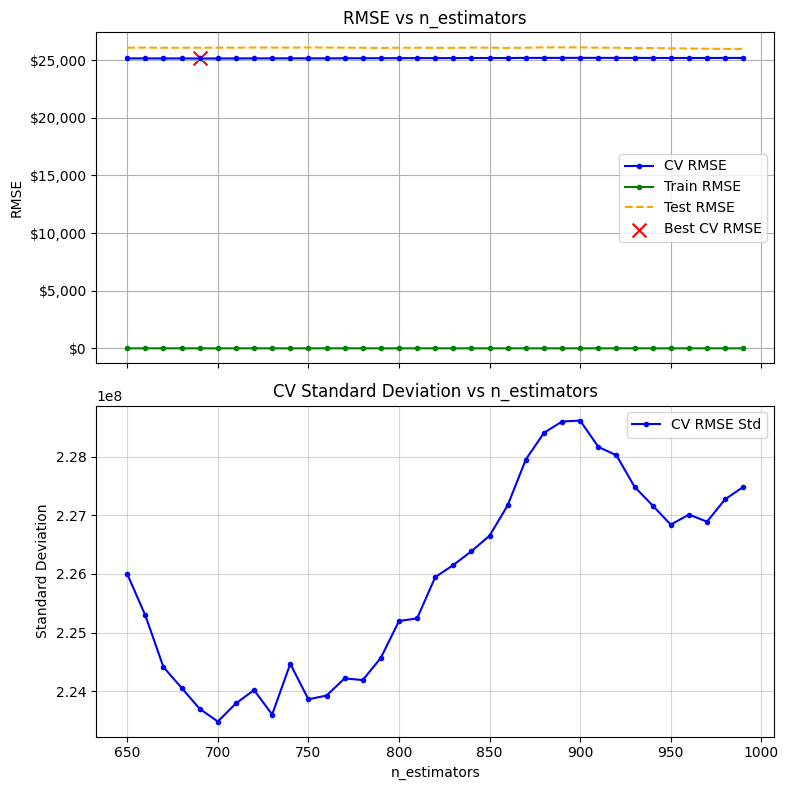

Execution Time: 00:16:38


In [25]:
# Your code here -- Add as many code cells as necessary

# Your code here -- Add as many code cells as necessary
# Your code here: 
# 1. Sweep n_estimators:
n_repeats=2
part_name = '2.B'
param = 'n_estimators'
parameter_list = range(650,1000,10)   
default_parameters = Parameters_BT.copy()
model = RandomForestRegressor
# Run bagging:
random_forests_result = sweep_parameter(model=model, 
                                    Parameters=default_parameters,
                                    param = param,
                                    parameter_list = parameter_list,
                                    X_train          = X_train,
                                    y_train          = y_train,
                                    X_test           = X_test,
                                    y_test           = y_test,
                                    verbose          = True,
                                    show_rmse        = True,
                                    n_iter_no_change = None,
                                    delta            = 0.001,
                                    n_jobs           = -1,
                                    n_repeats        = n_repeats)


In [26]:
# Set variables:
augmented_random_forests_result = random_forests_result.copy()
Parameters_BT = random_forests_result.copy()
augmented_random_forests_result['param'] = param
augmented_random_forests_result['part_name'] = part_name
augmented_random_forests_result['RMSE_found'] = np.sqrt(random_forests_result['MSE_found'])
print(f"augmented_random_forests_result: {augmented_random_forests_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_random_forests_result_list.append(augmented_random_forests_result)
log_message(f'{augmented_random_forests_result}')

augmented_random_forests_result: {'n_estimators': 690, 'max_features': 21, 'max_depth': None, 'bootstrap': False, 'random_state': 42, 'MSE_found': np.float64(632077089.3671937), 'max_samples': None, 'param': 'n_estimators', 'part_name': '2.B', 'RMSE_found': np.float64(25141.143358391513)}


Sweeping max_samples: 100%|██████████| 5/5 [01:12<00:00, 14.45s/it]


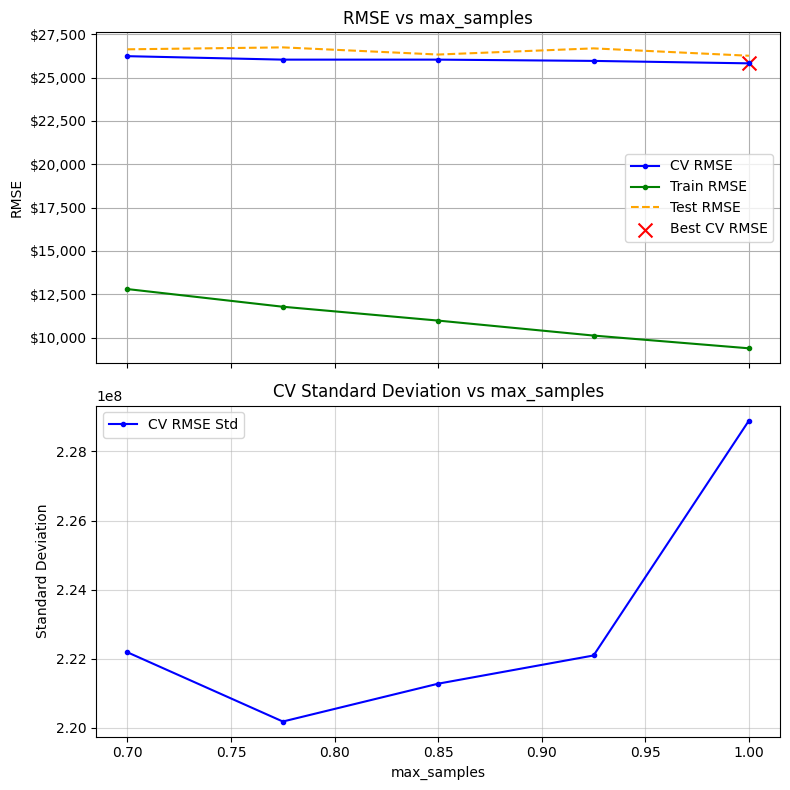

Execution Time: 00:01:12


In [27]:
# Your code here: 
# 2. Sweep max_samples: gives worse results
param = 'max_samples'
parameter_list = np.linspace(0.7, 1.0 ,5)  
default_parameters = Parameters_BT.copy() 
# default_parameters['max_samples'] = None # ValueError: `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`.
default_parameters['bootstrap'] = True    # ValueError: `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`.
model = RandomForestRegressor
random_forests_result = sweep_parameter(model=model, 
                                    Parameters=default_parameters,
                                    param = param,
                                    parameter_list = parameter_list,
                                    X_train          = X_train,
                                    y_train          = y_train,
                                    X_test           = X_test,
                                    y_test           = y_test,
                                    verbose          = True,
                                    show_rmse        = True,
                                    n_iter_no_change = None,
                                    delta            = 0.001,
                                    n_jobs           = -1,
                                    n_repeats        = n_repeats)

In [28]:
# Set variables:
augmented_random_forests_result = random_forests_result.copy()
Parameters_BT = random_forests_result.copy()
augmented_random_forests_result['param'] = param
augmented_random_forests_result['part_name'] = part_name
augmented_random_forests_result['RMSE_found'] = np.sqrt(random_forests_result['MSE_found'])
print(f"augmented_random_forests_result: {augmented_random_forests_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_random_forests_result_list.append(augmented_random_forests_result)
log_message(f'{augmented_random_forests_result}')

augmented_random_forests_result: {'n_estimators': 690, 'max_features': 21, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'MSE_found': np.float64(666675021.7069644), 'max_samples': np.float64(1.0), 'param': 'max_samples', 'part_name': '2.B', 'RMSE_found': np.float64(25820.05076886884)}


Sweeping max_features: 100%|██████████| 15/15 [04:18<00:00, 17.21s/it]


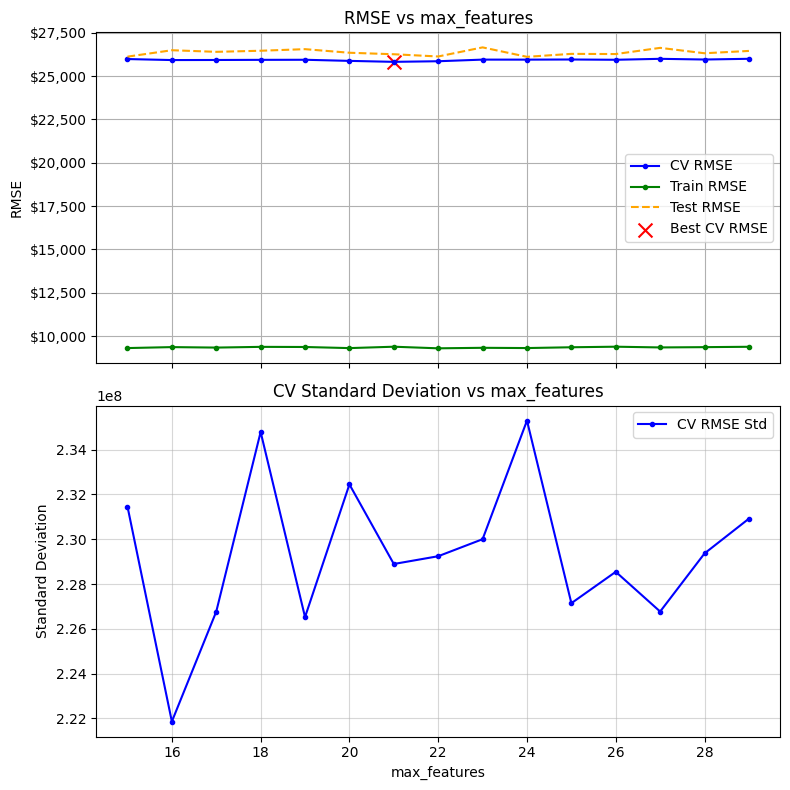

Execution Time: 00:04:18


In [29]:
# Your code here: 
# 3. Sweep max_features:
model = BaggingRegressor
param = 'max_features'
parameter_list = range(15,30)
default_parameters = Parameters_BT.copy()
model = RandomForestRegressor
random_forests_result = sweep_parameter(model=model, 
                                    Parameters=default_parameters,
                                    param = param,
                                    parameter_list = parameter_list,
                                    X_train          = X_train,
                                    y_train          = y_train,
                                    X_test           = X_test,
                                    y_test           = y_test,
                                    verbose          = True,
                                    show_rmse        = True,
                                    n_iter_no_change = None,
                                    delta            = 0.001,
                                    n_jobs           = -1,
                                    n_repeats        = n_repeats)

In [30]:
# Set variables:
augmented_random_forests_result = random_forests_result.copy()
Parameters_BT = random_forests_result.copy()
augmented_random_forests_result['param'] = param
augmented_random_forests_result['part_name'] = part_name
augmented_random_forests_result['RMSE_found'] = np.sqrt(random_forests_result['MSE_found'])
print(f"augmented_random_forests_result: {augmented_random_forests_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_random_forests_result_list.append(augmented_random_forests_result)
log_message(f'{augmented_random_forests_result}')

augmented_random_forests_result: {'n_estimators': 690, 'max_features': 21, 'max_depth': None, 'bootstrap': True, 'random_state': 42, 'MSE_found': np.float64(666675021.7069644), 'max_samples': np.float64(1.0), 'param': 'max_features', 'part_name': '2.B', 'RMSE_found': np.float64(25820.05076886884)}


Sweeping bootstrap: 100%|██████████| 2/2 [00:40<00:00, 20.41s/it]


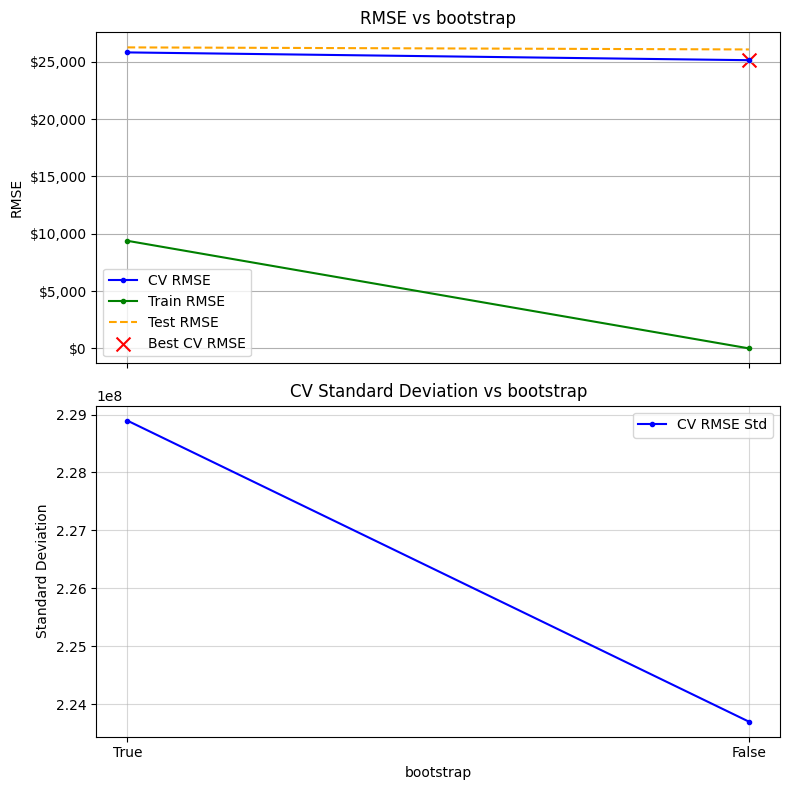

Execution Time: 00:00:40


In [31]:
# Your code here: 
# 3. Sweep bootstrap:
param = 'bootstrap'
parameter_list = [True,False] 
default_parameters = Parameters_BT.copy()
default_parameters['max_samples'] = None # ValueError: `max_sample` cannot be set if `bootstrap=False`. Either switch to `bootstrap=True` or set `max_sample=None`.
model = RandomForestRegressor
random_forests_result = sweep_parameter(model=model, 
                                    Parameters=default_parameters,
                                    param = param,
                                    parameter_list = parameter_list,
                                    X_train          = X_train,
                                    y_train          = y_train,
                                    X_test           = X_test,
                                    y_test           = y_test,
                                    verbose          = True,
                                    show_rmse        = True,
                                    n_iter_no_change = None,
                                    delta            = 0.001,
                                    n_jobs           = -1,
                                    n_repeats        = n_repeats)

In [32]:
# Set variables:
augmented_random_forests_result = random_forests_result.copy()
Parameters_BT = random_forests_result.copy()
augmented_random_forests_result['param'] = param
augmented_random_forests_result['part_name'] = part_name
augmented_random_forests_result['RMSE_found'] = np.sqrt(random_forests_result['MSE_found'])
print(f"augmented_random_forests_result: {augmented_random_forests_result}")
# Lists:
Parameters_BT_list.append(Parameters_BT)
augmented_random_forests_result_list.append(augmented_random_forests_result)
log_message(f'{augmented_random_forests_result}')

augmented_random_forests_result: {'n_estimators': 690, 'max_features': 21, 'max_depth': None, 'bootstrap': False, 'random_state': 42, 'MSE_found': np.float64(632077089.3671937), 'max_samples': None, 'param': 'bootstrap', 'part_name': '2.B', 'RMSE_found': np.float64(25141.143358391513)}


In [33]:
p2b_augmented_random_forests_result_df = pd.DataFrame(augmented_random_forests_result_list)
p2b_augmented_random_forests_result_df

,n_estimators,max_features,max_depth,bootstrap,random_state,MSE_found,param,part_name,RMSE_found,max_samples
0,750,NaN,None,True,42,7.190731e+08,n_estimators,2.A,26815.539173,NaN
1,750,NaN,None,True,42,7.190731e+08,max_samples,2.A,26815.539173,1.0
2,750,21.0,None,True,42,6.680717e+08,max_features,2.A,25847.082362,1.0
3,750,21.0,None,False,42,6.327669e+08,bootstrap,2.A,25154.857447,NaN
4,690,21.0,None,False,42,6.320771e+08,n_estimators,2.B,25141.143358,NaN
5,690,21.0,None,True,42,6.666750e+08,max_samples,2.B,25820.050769,1.0
6,690,21.0,None,True,42,6.666750e+08,max_features,2.B,25820.050769,1.0
7,690,21.0,None,False,42,6.320771e+08,bootstrap,2.B,25141.143358,NaN


In [34]:
print(p2b_augmented_random_forests_result_df['RMSE_found'].idxmin())
Parameters_BT_p2b = Parameters_BT_list[p2b_augmented_random_forests_result_df['RMSE_found'].idxmin()].copy()
RMSE_part2B = p2b_augmented_random_forests_result_df['RMSE_found'].min()

print(f"Parameters_BT_p2b: {Parameters_BT_p2b}")

RMSE_part2B

4
Parameters_BT_p2b: {'n_estimators': 690, 'max_features': 21, 'max_depth': None, 'bootstrap': False, 'random_state': 42, 'MSE_found': np.float64(632077089.3671937), 'max_samples': None}


np.float64(25141.143358391513)

### Problem 2.B Graded Answer

In [35]:
# TODO:  Set the variable to best CV RMSE score found after Part 2.B (it may not be different than Part 2.A)

a2b = RMSE_part2B                                # Just to get it to run without error; your answer here           

print(f'a2b = ${a2b:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a2b = $25,141.14


### **Part 2.C: Use `GridSearchCV` for Exhaustive Search**  

In [ ]:
# Your code here -- Add as many code cells as necessary
# {'n_estimators': 690, 'max_features': 21, 'max_depth': None, 'bootstrap': False, 'random_state': 42, 'max_samples': None}

# Run GridSearchCV

# Record start time
start = time.time()

# Define the model
rf_model = RandomForestRegressor(random_state=random_state)

# Define the parameter grid
param_dist = {
    'n_estimators': range(680,720,10),          # < - set  here
    'bootstrap': np.array([False]),         # < - set  here
    'max_samples' : [None],                 # < - set  here
    'max_features': range(20,25),
    'min_samples_leaf': [1],
}

# Use GridSearchCV to find the best parameters
search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_dist,
    scoring='neg_mean_squared_error',  # MSE but negated for maximization by GridSearchCV
    cv=5,  # Number of folds for cross-validation -- Reduce this if efficiency is an issue
    n_jobs=-1,  # Use all available cores
    return_train_score=True
)

# Fit the GridSearchCV
search.fit(X_train, y_train)  

# Extract results into a DataFrame
results = pd.DataFrame(search.cv_results_)

# Select relevant columns for readability
results = results[[
    'param_n_estimators',
    'param_min_samples_leaf',
    'param_max_features',
    'mean_test_score',
    'std_test_score',
    'mean_train_score',  # Include training score
    'std_train_score',   # Include standard deviation of training score
    'rank_test_score'
]]

# Convert negative MSE to positive
results['mean_test_score'] = -results['mean_test_score']
results['mean_train_score'] = -results['mean_train_score']

# Sort by rank (best scores first)
results = results.sort_values(by='rank_test_score')

# Rename columns for printing only
renamed_results = results.rename(
    columns={
        'param_n_estimators': 'n_estimators',
        'param_min_samples_leaf': 'min_samples_leaf',
        'param_max_features': 'max_samples',
        'mean_test_score': 'mean_cv_score',
        'std_test_score': 'std_cv_score',
        'mean_train_score': 'mean_train_score',
        'std_train_score': 'std_train_score'
    }
).drop(columns=['rank_test_score'])  # Drop the rank column for readability

# Print the results as a table
print("\nSearch Results (Top 5):\n")
print(renamed_results.head(5).to_string(index=False))  # Show the top 5 results with new headers

# Best parameters and test performance
print(f"\nBest Parameters: {search.best_params_}")
print(f"Best CV MSE: {-search.best_score_:.4f}")

# Evaluate on the test set
y_pred_rf = search.best_estimator_.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_rf)

print(f"Test MSE:    {test_mse:.4f}")

# Record end time and execution time
end = time.time()
print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end-start)))


Search Results (Top 5):

 n_estimators  min_samples_leaf  max_samples  mean_cv_score  std_cv_score  mean_train_score  std_train_score
          690                 1           21   5.815376e+08  1.009917e+08          0.018595         0.025082
          680                 1           21   5.815578e+08  1.010075e+08          0.019146         0.025826
          700                 1           21   5.818803e+08  1.013984e+08          0.018068         0.024371
          710                 1           21   5.824861e+08  1.018219e+08          0.017562         0.023689
          710                 1           24   5.854525e+08  1.015582e+08          0.001693         0.003386

Best Parameters: {'bootstrap': np.False_, 'max_features': 21, 'max_samples': None, 'min_samples_leaf': 1, 'n_estimators': 690}
Best CV MSE: 581537604.0871
Test MSE:    680038074.6982


NameError: name 'format_time' is not defined

In [53]:
print(f"Best CV RMSE: {np.sqrt(-search.best_score_):.4f}")
Parameters_BT_p2c = search.best_params_
RMSE_part2C = np.sqrt(-search.best_score_)

print(f"RMSE_part2A: {RMSE_part2A}")
print(f"RMSE_part2B: {RMSE_part2B}")
print(f"RMSE_part2C: {RMSE_part2C}")

if RMSE_part2C < RMSE_part2B:
    print(f"Success!: RMSE_part2C: {RMSE_part2C:,.2f} is less than RMSE_part1B: {RMSE_part2B:,.2f}")
else:
    print(f"Failure!: RMSE_part2B: {RMSE_part2C:,.2f} is greater than RMSE_part2B: {RMSE_part2B:,.2f}")

Best CV RMSE: 24115.0908
RMSE_part2A: 25154.857446518803
RMSE_part2B: 25141.143358391513
RMSE_part2C: 24115.090795746888
Success!: RMSE_part2C: 24,115.09 is less than RMSE_part1B: 25,141.14


### Problem 2.C Graded Answer

In [54]:
# TODO:  Set the variable to best CV RMSE score found in Part C (it may not be different than Parts A and B)

a2c = RMSE_part2C                        # Just to get it to run without error; your answer here           

print(f'a2c = ${a2c:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a2c = $24,115.09


### **Part 2.D: Evaluate Model Generalization**  


In [ ]:
print(f"Parameters_BT_p2a: {Parameters_BT_p2a}")
print(f"Parameters_BT_p2b: {Parameters_BT_p2b}")
print(f"Parameters_BT_p2c: {Parameters_BT_p2c}")

model_1B = RandomForestRegressor
P_temp = Parameters_BT_p2a.copy()
cv_mse, std_cv, train_mse, test_mse = run_model(
            model=model_1B,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=-1,
            **P_temp
        )

std_cv_A = std_cv
train_rmse_A = np.sqrt(train_mse)
cv_rmse_A = np.sqrt(cv_mse)
test_rmse_A = np.sqrt(test_mse)
cv_mse_std_A = np.std(std_cv)
print("===== Model Comparison =====")
print(f"Part A Model CV RMSE: {cv_rmse_A:.2f} (Std: {cv_mse_std_A:.2f})")
print(f"Part A Model Test RMSE: {test_rmse_A:.2f}")
print(f"Part A Model Train RMSE: {train_rmse_A:.2f}")
print(f"Part A Model CV MSE Std: {std_cv_A:.2f}")

# -------------------
P_temp = Parameters_BT_p2b.copy()
cv_mse, std_cv, train_mse, test_mse = run_model(
            model=model_1B,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=-1,
            **P_temp
        )

std_cv_B = std_cv
train_rmse_B = np.sqrt(train_mse)
cv_rmse_B = np.sqrt(cv_mse)
test_rmse_B = np.sqrt(test_mse)
cv_mse_std_B = np.std(std_cv)
print("===== Model Comparison =====")
print(f"Part B Model CV RMSE: {cv_rmse_B:.2f} (Std: {cv_mse_std_B:.2f})")
print(f"Part B Model Test RMSE: {test_rmse_B:.2f}")
print(f"Part B Model Train RMSE: {train_rmse_B:.2f}")
print(f"Part B Model CV MSE Std: {std_cv_B:.2f}")

# -------------
P_temp = Parameters_BT_p2c.copy()
cv_mse, std_cv, train_mse, test_mse = run_model(
            model=model_1C,
            X_train=X_train, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=-1,
            **P_temp
        )
std_cv_C = std_cv
train_rmse_C = np.sqrt(train_mse)
cv_rmse_C = np.sqrt(cv_mse)
test_rmse_C = np.sqrt(test_mse)
cv_mse_std_C = np.std(std_cv)
print("===== Model Comparison =====")
print(f"Part C Model CV RMSE: {cv_rmse_C:.2f} (Std: {cv_mse_std_C:.2f})")
print(f"Part C Model Test RMSE: {test_rmse_C:.2f}")
print(f"Part C Model Train RMSE: {train_rmse_C:.2f}")
print(f"Part C Model CV MSE Std: {std_cv_C:.2f}")

# --------------------
a2d_answer = 1 # expected
print("Selected Model: Part B (Manual Tuning)")
print(f"best parameters : {Parameters_BT_p2b}")
print(f"a1d Answer : {a2d_answer}")


### Problem 2.D Graded Answer

In [ ]:
# TODO:  Which of options 1, 2, or 3 did you choose?

a2d = 2                               # Should be integer 1, 2, or 3          

print(f'a2d = {a2d}')                    # Do not change this line, and DO NOT print anything else in this cell

a2d = Ellipsis


### Problem 2.D Non-Graded Answer but Please Do It

Describe in a couple of sentences how your examination of the plots led to your decision. (You'll be expected to answer many such questions when you do your project, so this is good practice, and I'll read as many of your answers as I can.)

Your Answer: 






### **Part 2.E: Report the Test Score of the Best Model**  
Once you have selected the best model, **report its final test score** and answer the graded question.   


In [ ]:
# Run your best model here on the test data and print out the resulting test RMSE. 
print("===== Part 1.E: Final Test Score =====")
print(f"Final Test RMSE: {test_rmse_B:.2f} dollars") 

final_test_score = test_rmse_B


### Problem 2.E Graded Answer

In [ ]:
# TODO:  Assign the variable to the test RMSE of the model you selected in Part E

a2e = final_test_score                               # Just to get it to run without error; your answer here           

print(f'a2e = ${a2e:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a2e = $0.00


## Problem Three: Gradient Boosting Trees

Now you will do the exact same thing as in Problem One, but for `GradientBoostingRegressor`. 
(Instructions are omitted, refer to them above.) 

### **Part 3.A: Iteratively Sweep Parameters and Visualize Results using `sweep_parameter(...)`**  

In [41]:
Default_Parameters_GradientBoosting = {
    'learning_rate'           : 0.1,             # Shrinks the contribution of each tree. Affects the speed of learning and overfitting.
    'n_estimators'            : 100,             # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    'max_depth'               : 3,               # Maximum depth of individual trees. Controls model complexity.
    'max_features'            : None,            # Number of features to consider when looking for best split. Can help reduce overfitting.
    'random_state'            : 42,              # Controls randomness of boosting. Useful for reproducibility.
    'MSE_found'               : float('inf')     # NOT a parameter, but will record the MSE found for the current parameter choices
}


In [42]:
# Your code here -- Add as many code cells as necessary



### Problem 3.A Graded Answer

In [43]:
# TODO:  Set the variable to best CV RMSE score found after Part 3.A

a3a = 0.0                                # Just to get it to run without error; your answer here (remember to use the RMSE)         

print(f'a3a = ${a3a:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a3a = $0.00


### **Part 3.B: Refine Parameters for Model Stability**  


In [44]:
# Your code here -- Add as many code cells as necessary




### Problem 3.B Graded Answer

In [45]:
# TODO:  Set the variable to best CV RMSE score found after Part 3.B (it may not be different than Part 3.A)

a3b = 0.0                                # Just to get it to run without error; your answer here           

print(f'a3b = ${a3b:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a3b = $0.00


### **Part 3.C: Use `GridSearchCV` for Exhaustive Search**  

In [46]:
# Your code here -- Add as many code cells as necessary




### Problem 3.C Graded Answer

In [47]:
# TODO:  Set the variable to best CV RMSE score found in Part C (it may not be different than Parts A and B)

a3c = 0.0                                # Just to get it to run without error; your answer here           

print(f'a3c = ${a3c:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a3c = $0.00


### **Part 3.D: Evaluate Model Generalization**  


### Problem 3.D Graded Answer

In [48]:
# TODO:  Which of options 1, 2, or 3 did you choose?

a3d = ...                                # Should be integer 1, 2, or 3          

print(f'a3d = {a3d}')                    # Do not change this line, and DO NOT print anything else in this cell

a3d = Ellipsis


### Problem 3.D Non-Graded Answer but Please Do It

Describe in a couple of sentences how your examination of the plots led to your decision. (You'll be expected to answer many such questions when you do your project, so this is good practice, and I'll read as many of your answers as I can.)

Your Answer: 






### **Part 3.E: Report the Test Score of the Best Model**  
Once you have selected the best model, **report its final test score** and answer the graded question.   


In [49]:
# Run your best model here on the test data and print out the resulting test RMSE. 



### Problem 3.E Graded Answer

In [50]:
# TODO:  Assign the variable to the test RMSE of the model you selected in Part E

a3e = 0.0                                # Just to get it to run without error; your answer here           

print(f'a3e = ${a3e:,.2f}')              # Do not change this line, and DO NOT print anything else in this cell

a3e = $0.00


## Appendix 1: Which `BaggingRegressor` parameters are most important?

When exploring ensemble methods like `BaggingRegressor`, it's best to focus at first on the parameters that directly influence both the behavior of the individual base estimators and the overall ensemble performance. Here is an approximate ordering of the parameters from most significant to least. In this homework, we will experiment with the top **four** parameters.

---

**Most Important Parameters**

1. **n_estimators** (default: **10**)  
   *Determines the number of base estimators in the ensemble. Increasing this number can reduce variance and improve performance, though it comes with higher computational cost.*

2. **max_samples** (default: **1.0**)  
   *Specifies the number (or fraction) of samples to draw from the training set for each base estimator. This is crucial for controlling the diversity of the estimators and can directly affect bias and variance.*

3. **max_features** (default: **1.0**)  
   *Specifies the number (or fraction) of features to consider when training each base estimator. Adjusting this parameter can help manage overfitting by limiting the complexity of each individual estimator.*

4. **bootstrap** (default: **True**)  
   *Indicates whether samples are drawn with replacement. Bootstrap sampling introduces randomness into the training process, leading to more diverse estimators and often improved ensemble performance.*

---

**Less Important Parameters**

5. **base_estimator** (default: **None**)  
   *Defines the underlying estimator to be used. If set to `None`, BaggingRegressor defaults to using a DecisionTreeRegressor. Experimenting with different base estimators can provide valuable insights into model performance.*

6. **oob_score** (default: **False**)  
   *If enabled, the model uses out-of-bag samples to estimate the generalization error, providing an internal validation metric without the need for a separate validation set.*

7. **bootstrap_features** (default: **False**)  
   *Specifies whether features are sampled with replacement. This additional layer of randomness can further increase estimator diversity, though its impact is typically less significant than sample bootstrapping.*


## Appendix 2: Which `RandomForestRegressor` parameters are most important?

We will focus on the top **four** parameters in this list for `RandomForestRegressor`. 

---

**Most Important Parameters**

1. **n_estimators** (default: **100**)  
   *Determines the number of trees in the forest. Increasing this number generally improves performance and model stability, albeit with higher computational cost.*

2. **max_features** (default: **None**)  
   *Specifies the number of features to consider when looking for the best split. Adjusting this can help manage the bias-variance trade-off and affect the diversity among the trees.*

3. **max_depth** (default: **None**)  
   *Limits the depth of each tree. Restricting the maximum depth is an effective way to control overfitting and reduce the complexity of the model.*

4. **bootstrap** (default: **True**)  
   *Indicates whether bootstrap samples are used when building trees. Enabling bootstrap sampling introduces randomness into the training process, which can improve the generalization of the ensemble.*

---

**Less Important Parameters**

5. **min_samples_split** (default: **2**)  
   *Defines the minimum number of samples required to split an internal node. Tuning this parameter affects how the tree grows, influencing its granularity and robustness.*

6. **min_samples_leaf** (default: **1**)  
   *Specifies the minimum number of samples that must be present in a leaf node. This parameter ensures that leaves are not created with too few samples, which can help mitigate overfitting.*

7. **oob_score** (default: **False**)  
   *If enabled, uses out-of-bag samples to estimate the generalization error, providing an internal validation measure without the need for a separate validation set.*

8. **criterion** (default: **'squared_error'**)  
   *Determines the function used to measure the quality of a split. While its effect is typically subtle, experimenting with this parameter can reveal how different error metrics impact performance.*



## Appendix 3: Which `GradientBoostingRegressor` parameters are most important?

We will focus on the top **four** parameters in this list for `GradientBoostingRegressor`. 

---

**Most Important Parameters**

1. **learning_rate** (default: **0.1**)  
   *Controls the contribution of each individual tree. A lower learning rate generally requires more trees but can lead to improved generalization.*

2. **n_estimators** (default: **100**)  
   *Specifies the number of boosting stages (i.e., the number of trees in the ensemble). More estimators can improve performance but also increase the risk of overfitting if not tuned properly.*

3. **max_depth** (default: **3**)  
   *Limits the depth of the individual regression trees. Restricting the depth helps control overfitting and reduces the complexity of each base learner.*

4. **max_features** (default: **None**)  
   *Controls the number of features to consider when looking for the best split. Adjusting this can influence the bias-variance trade-off of the model.*
   
---

**Less Important Parameters**

5. **min_samples_split** (default: **2**)  
   *Defines the minimum number of samples required to split an internal node. This parameter controls the growth of each tree and can prevent overly specific splits.*

6. **min_samples_leaf** (default: **1**)  
   *Specifies the minimum number of samples that must be present in a leaf node. This helps in ensuring that trees do not become too tailored to the training data.*

7. **max_leaf_nodes** (default: **None**)  
    *An optional parameter that sets a maximum number of leaf nodes for each tree. This can provide an additional way to control the complexity of the model.*

8. **subsample** (default: **1.0**)  
   *Determines the fraction of samples used for fitting each individual tree. Values less than 1.0 introduce randomness into the boosting process, which can help reduce overfitting.*

9. **loss** (default: **'squared_error'**)  
   *Determines the loss function to be optimized during training. Different loss functions can be used depending on the specific characteristics of the regression problem.*





## Appendix 4: Tips on Tuning Complicated Models

### Using `sweep_parameters` for Single-Parameter Exploration

1. **Purpose**  
   - The function `sweep_parameters` automates the process of iterating over a list of parameter values (e.g., `n_estimators` in a random forest) and training a model for each value.
   - It then computes and plots, for each value in the specified range:
     - **Training MSE**: How well the model fits the training data.  
     - **Cross-Validation (CV) MSE**: An estimate of how well the model generalizes, averaged over multiple folds (and possibly multiple repeats).  
     - **Test MSE**: If you have a dedicated test set, this provides a final check of out-of-sample performance.  
     - **Std of CV Scores**: The standard deviation across cross-validation folds (and repeats), indicating how stable or variable the model performance is.

2. **Interpretation of the Plots**  
   - **Training MSE vs. Parameter Value**:  
     Helps you see when the model is overfitting (training MSE much lower than CV MSE) or underfitting (training MSE is high).
   - **CV MSE vs. Parameter Value**:  
     Typically your key metric for choosing the parameter setting. Look for a valley in this curve.
   - **Test MSE vs. Parameter Value**:  
     The precise values here are dependent on the random split of training and testing sets; we include it so that we may examine the **gap** between CV MSE and test MSE (see Appendix 5). 
   - **Std of CV Scores vs. Parameter Value**:  
     Large standard deviation means the model’s performance is inconsistent across folds (and repeats). You may want to pick a parameter setting that not only has a low mean CV MSE but also a lower standard deviation for more reliable performance.
   - **Beware of the Scale of the Plots!**
     The plots are drawn to fit the values, and the scale of the y-axis may vary quite a lot!  Therefore, you can not just "eyeball" a curve and make quick decisions that, say, the std of the CV score indicates something important. **It depends on the scale of the y-axis.**  If the curve(s) are relatively flat, the differences shown may in reality be quite small!  Just be careful to observe both the shape and the scale of the plots. 
3. **Sweeping Strategy**  
   - **Coarse to Fine**: Start with wide ranges and larger steps (e.g., 100–1000 in increments of 100). Narrow down once you see the region where the CV MSE is lowest. Then reduce step sizes in that region (e.g., steps of 25 or 10).
   - **Stop Early if Converged**: If the CV MSE difference between 1400 and 1405 `n_estimators` is negligible, further fine-tuning is unlikely to yield real improvement.

**Note:** We will not be using early stopping in this homework, because we are still learning how to interpret model performance, but with further experience, you may find that early stopping will help you zero in on the best models. 

---

### Adjusting Repeated Cross-Validation

1. **Why Repeat?**  
   - Cross-validation is already a good measure of generalization. However, it’s still sensitive to how the data is split into folds. Repeating cross-validation with different random folds provides a more robust estimate (reducing the variance of the CV score).

2. **When to Increase Repeats**  
   - **Early Sweeps**: Use 1 or 2 repeats when you are scanning large ranges of your parameter. The goal is speed and a rough idea of where the “sweet spot” is, so you don’t want to spend too much computation time on many repeats.
   - **Narrowed Sweeps**: Once you have focused on a smaller interval (e.g., 1300–1500 in increments of 25 for `n_estimators`), increase repeats to 5 (ok) or 10 (ideal). This gives you a more stable estimate and helps confirm the final optimal setting with greater confidence.

3. **Trade-Offs**  
   - **Computation**: Each extra repeat multiplies the total training time. If you have limited computational resources, keep the repeats modest until you are zeroing in on a smaller range.
   - **Stability**: More repeats lower the variance of your CV estimate. If you see widely fluctuating performance across folds, use more repeats to gauge if it’s truly unstable or just a byproduct of the data splits.

---

### Tips for a Smooth Workflow

1. **Plot and Observe**  
   Always visualize the training/CV/test MSE vs. parameter and the CV std plots. Look for patterns of overfitting or underfitting, and watch the standard deviation for instability.

2. **Document Iterations using Parameter Dictionaries**  
   In the video notebook for Week 7 on Gradient Boosting, we stored the parameter dictionaries in a list; you may wish to do something similar, or find some other way of recording your results. 

3. **Scale Up Gradually**  
   Start simply (fewer repeats, coarse parameter steps), refine as you learn more, and only then use heavier computations (more repeats, fine steps).

4. **Use `GridSearchCV` Judiciously**  
   Grid and random search are powerful tools, but can lead to hours of computation--and without a progress bar to tell you how far you've gotten! Use these tools to refine and verify your search after you understand the search space through plotting and visualization. The same "scale up gradually" approach should be used here as well. 

5. **Take Advantage of Parallelism with `n_jobs=-1`**  
   Many scikit-learn functions, such as cross-validation and grid search routines, allow you to specify the `n_jobs` parameter. We have set the default at `n_jobs=-1` to use all available CPU cores to speed up processing.  
   - **If You See Warnings**: Sometimes, you may get a message like “A worker stopped while some jobs were still running.” This can happen if your system is running out of memory or hitting other resource limits. Mostly you can ignore these.  But if you are concerned, reduce the number of jobs (e.g., `n_jobs=4`) to reduce the load.  You can also track the system load using the Activity Monitor (on Mac) or Task Manager (on PC). 
   - **Utilize a Robust Environment**: If you need more parallel processing power, consider using a computing environment such as Google Colab, which offers additional CPU cores to handle more intensive jobs efficiently.

By combining the coarse-to-fine parameter sweeping with increasing repeats as you zero in on the most promising configurations, you balance computational efficiency with the need for robust, stable model performance estimates.

## Appendix 5:  Model Selection:  When is a model overfitting? Which model to choose?

- **Minimize Mean CV MSE:** Aim for the model configuration with the lowest mean CV MSE as a primary indicator of good generalization.
- **Stable CV Performance:** Choose a model where the CV MSE either
  - Reaches a minimum and then starts to increase, or
  - Plateaus—indicating additional improvements are marginal—rather than a continuously decreasing trend that may signal overfitting.
- **Gap Analysis:** Watch out for an *increasing gap* between the mean CV MSE and testing MSE. A growing gap can be a sign of overfitting to the training data. Do not worry about the *size* of the gap, which will primarily be due to the random split between training and testing sets; it is the *change* in the gap between the two that is most significant. 
- **CV Score Consistency:** Favor models with a lower standard deviation in CV scores, as this reflects more consistent performance across different data splits.
- **Be Aware of the Scale:** You need to look not only at the shape of the curves, but the scale of the y-axis, particularly with the std of the CV scores.  Beware of assuming that there is a significant difference unless you take account of the actual values!  